# Problem Statement


Have there been times when you just instantly like a song? Or some bops just make you want to dance? Is it the notes you like or just the lyrics? Can we categorize our likes and dislikes to the genres of the songs or does our brain chemistry recognize something deeper like beats per minute or overall valence of the lyrics. 
For people in the entertainment industry - if you are a dj or handle the background scores of a multi-million dollar movie project, their success depends on how a majoriy of the audience will react to their music. 

This project attempts to answer this very burning question - what makes a song liked by most people.


# About the Dataset

The data used for this project are sourced using the Spotify API called spotipy -  the Python library for the Spotify Web API to procure data on tracks and artists. Using this we have pulled our liked songs from our spotify account. This data will help train the model used to recommend similar songs. <br>
 <br>
 
Another dataset has been taken from Kaggle. The original data set consists of 3 csv files containing information about artists, tracks and albums. <br>
This dataset is a set of all available songs across all countries after 2010. After the model is trained it will select songs from this data set and recommend songs according thefeatures of our liked songs. <br>

Since we intend to use the data for all users, the first step would be to preprocess the data and combine them together to be used in a more efficient manner.
<br>

The file containing tracks details has information about tracks such as their id, names, playlists that they are part of, countries in which they are available etc.<br>

The file containing albums details has the information about albums such as names, the dates they were releases on, numbers of the songs in the playlist, and the country of availability.

# Process followed

1. Clean/pre-process the data
2. Basic analysis on the data
3. Model Building
4. Prediction

Since the data set is very huge, we are going to restrict it to have the songs only after 1990 so that the data size becomes manageable to work with.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import seaborn as sns
import ast
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [3]:
data_dir = "SpotGenTrack/Data Sources/"
albums_data = pd.read_csv(data_dir+"spotify_albums.csv")
artists_data = pd.read_csv(data_dir+"spotify_artists.csv")
tracks_data = pd.read_csv(data_dir+"spotify_tracks.csv")

In [4]:
def join_genre_and_date(artist_df, album_df, track_df):
    album = album_df.rename(columns={'id':"album_id"}).set_index('album_id')
    artist = artist_df.rename(columns={'id':"artists_id",'name':"artists_name"}).set_index('artists_id')
    track = track_df.set_index('album_id').join(album['release_date'], on='album_id' )
    track.artists_id = track.artists_id.apply(lambda x: x[2:-2])
    track = track.set_index('artists_id').join(artist[['artists_name','genres']], on='artists_id' )
    track.reset_index(drop=False, inplace=True)
    track['release_year'] = pd.to_datetime(track['release_date'], errors='coerce').dt.year
    track.drop(columns = ['Unnamed: 0','country','track_name_prev','track_number','type'], inplace = True)
    
    return track[track.release_year >= 2010]

In [5]:
def get_filtered_track_df(df, genres_to_include):
    df['genres'] = df.genres.apply(lambda x: [i[1:-1] for i in str(x)[1:-1].split(", ")])
    df_exploded = df.explode("genres")[df.explode("genres")["genres"].isin(genres_to_include)]
    df_exploded.loc[df_exploded["genres"]=="korean pop", "genres"] = "k-pop"
    df_exploded_indices = list(df_exploded.index.unique())
    df = df[df.index.isin(df_exploded_indices)]
    df = df.reset_index(drop=True)
    return df

In [6]:
genres_to_include = genres = ['dance pop', 'electronic', 'electropop', 'hip hop', 'jazz', 'k-pop', 'latin', 'pop', 'pop rap', 'r&b', 'rock']
track_with_year_and_genre = join_genre_and_date(artists_data, albums_data, tracks_data)
filtered_track_df = get_filtered_track_df(track_with_year_and_genre, genres_to_include)

In [7]:
filtered_track_df["uri"] = filtered_track_df["uri"].str.replace("spotify:track:", "")
filtered_track_df = filtered_track_df.drop(columns=['analysis_url', 'available_markets']).drop_duplicates(subset='name', keep="first")

<Axes: >

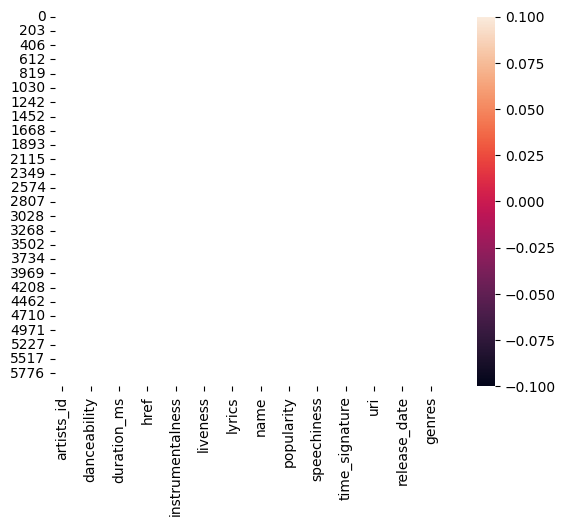

In [8]:
sns.heatmap(filtered_track_df.isnull(), linewidth=0.5)

In [9]:
filtered_track_df.to_csv("spotify_final_data.csv", index=False)

We are writing the final data that we are going to use into a csv file and retain permanently

# Exploratory Data Analysis

In [10]:
filtered_track_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5235 entries, 0 to 6052
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artists_id        5235 non-null   object 
 1   acousticness      5235 non-null   float64
 2   danceability      5235 non-null   float64
 3   disc_number       5235 non-null   float64
 4   duration_ms       5235 non-null   float64
 5   energy            5235 non-null   float64
 6   href              5235 non-null   object 
 7   id                5235 non-null   object 
 8   instrumentalness  5235 non-null   float64
 9   key               5235 non-null   float64
 10  liveness          5235 non-null   float64
 11  loudness          5235 non-null   float64
 12  lyrics            5235 non-null   object 
 13  mode              5235 non-null   float64
 14  name              5235 non-null   object 
 15  playlist          5235 non-null   object 
 16  popularity        5235 non-null   float64
 17  

In [11]:
filtered_track_df.head()

,artists_id,acousticness,danceability,disc_number,duration_ms,energy,href,id,instrumentalness,key,...,speechiness,tempo,time_signature,track_href,uri,valence,release_date,artists_name,genres,release_year
0,68WwJXWrpo1yVOOIZjLSeT,0.026800,0.506,1.0,248777.0,0.741,https://api.spotify.com/v1/tracks/0UATU9OJxh4m...,0UATU9OJxh4m3fwDljdGZn,0.000027,1.0,...,0.0349,94.042,4.0,https://api.spotify.com/v1/tracks/0UATU9OJxh4m...,0UATU9OJxh4m3fwDljdGZn,0.236,2018-09-28,Evalyn,"[electropop, indie electro-pop, indie poptimis...",2018.0
1,6pSsE5y0uJMwYj83KrPyf9,0.133000,0.629,1.0,207396.0,0.706,https://api.spotify.com/v1/tracks/0h7Ld5CvgzaU...,0h7Ld5CvgzaUN1zA3tdyPq,0.000000,1.0,...,0.4360,81.220,4.0,https://api.spotify.com/v1/tracks/0h7Ld5CvgzaU...,0h7Ld5CvgzaUN1zA3tdyPq,0.543,2019-01-25,Dawn Richard,"[alternative r&b, deep pop r&b, escape room, h...",2019.0
2,1Ffb6ejR6Fe5IamqA5oRUF,0.000123,0.409,1.0,275013.0,0.859,https://api.spotify.com/v1/tracks/6r7bDk4J0Okw...,6r7bDk4J0Okw4ezTBUQXo3,0.000000,10.0,...,0.0367,154.023,4.0,https://api.spotify.com/v1/tracks/6r7bDk4J0Okw...,6r7bDk4J0Okw4ezTBUQXo3,0.473,2015-09-11,Bring Me The Horizon,"[melodic metalcore, metalcore, rock, screamo]",2015.0
3,7oPftvlwr6VrsViSDV7fJY,0.000046,0.419,1.0,180853.0,0.971,https://api.spotify.com/v1/tracks/3oqYMRKQcwyN...,3oqYMRKQcwyNmFn1VD2ukD,0.000014,7.0,...,0.0909,180.033,4.0,https://api.spotify.com/v1/tracks/3oqYMRKQcwyN...,3oqYMRKQcwyNmFn1VD2ukD,0.677,2016-10-07,Green Day,"[permanent wave, pop punk, punk, rock]",2016.0
4,3DiDSECUqqY1AuBP8qtaIa,0.569000,0.616,1.0,231667.0,0.446,https://api.spotify.com/v1/tracks/2iejTMy9XZ8G...,2iejTMy9XZ8Gaae0aQ2yl0,0.000008,7.0,...,0.1090,118.539,3.0,https://api.spotify.com/v1/tracks/2iejTMy9XZ8G...,2iejTMy9XZ8Gaae0aQ2yl0,0.197,2019-02-08,Alicia Keys,"[hip pop, neo soul, pop, r&b, urban contemporary]",2019.0


In [12]:
filtered_track_df.describe()

,acousticness,danceability,disc_number,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,release_year
count,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000
mean,0.288523,0.608873,1.020821,225710.761796,0.632617,0.055268,5.217383,0.184137,-6.757434,0.644126,52.842980,0.081828,119.944166,3.938682,0.480674,2016.008214
std,0.299763,0.152527,0.217996,58289.784845,0.212367,0.183848,3.565497,0.157147,3.181013,0.478823,13.502508,0.088101,28.729734,0.364481,0.238470,2.514028
min,0.000000,0.000000,1.000000,3500.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2010.000000
25%,0.032250,0.510000,1.000000,194232.000000,0.483000,0.000000,2.000000,0.097300,-8.204000,0.000000,44.000000,0.035500,97.135500,4.000000,0.288000,2014.000000
50%,0.164000,0.622000,1.000000,217760.000000,0.661000,0.000002,5.000000,0.122000,-6.152000,1.000000,54.000000,0.048700,119.979000,4.000000,0.464000,2017.000000
75%,0.500000,0.717500,1.000000,245867.000000,0.805000,0.000504,8.000000,0.212000,-4.656000,1.000000,62.000000,0.083900,137.961000,4.000000,0.667000,2018.000000
max,0.995000,0.976000,9.000000,944613.000000,0.997000,0.984000,11.000000,0.989000,-0.330000,1.000000,97.000000,0.941000,209.474000,5.000000,0.975000,2019.000000


In [13]:
pd.isnull(filtered_track_df).sum()

artists_id          0
acousticness        0
danceability        0
disc_number         0
duration_ms         0
energy              0
href                0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
lyrics              0
mode                0
name                0
playlist            0
popularity          0
preview_url         0
speechiness         0
tempo               0
time_signature      0
track_href          0
uri                 0
valence             0
release_date        0
artists_name        0
genres              0
release_year        0
dtype: int64

As we can see that the data doesn't contain any null values so we are good to start our data analysis

Lets try to determine the most and least famous songs 

In [14]:
least_famous_songs = filtered_track_df.sort_values('popularity', ascending=True).head(10)
least_famous_songs[['name', 'artists_name', 'popularity']]

,name,artists_name,popularity
3015,I Am The Champion,B.o.B,0.0
4640,My favorite song!,Jennifer Lopez,0.0
5417,Maybe It’s Not Our Fault,Yerin Baek,0.0
2660,Shout out,Jennifer Lopez,0.0
3478,New single,Jennifer Lopez,0.0
5605,Talk - Single Edit,Two Door Cinema Club,0.0
3461,My debut,Jennifer Lopez,0.0
2107,Somos Uno,Yandel,0.0
1491,Pretty Dark - Demo,Grimes,0.0
3790,Selena,Jennifer Lopez,0.0


In [15]:
most_famous_songs = filtered_track_df.sort_values('popularity', ascending=False).head(10)
most_famous_songs[['name', 'artists_name', 'popularity']]

,name,artists_name,popularity
6038,Sweet but Psycho,Ava Max,97.0
5292,SICKO MODE,Travis Scott,94.0
5383,Let Me Down Slowly,Alec Benjamin,93.0
5485,Money,Cardi B,90.0
6052,Last Hurrah,Bebe Rexha,88.0
5379,Shotgun,George Ezra,88.0
5331,I Like Me Better,Lauv,88.0
4433,Saturday Nights,Khalid,87.0
5120,Happier,Ed Sheeran,87.0
6023,My Bad,Khalid,86.0


## Examining the predictor variables

We should visualize the distribution of the predictor variables in all the songs available in the dataset.

When you go to a party, you don't dance on all songs. You dance on songs you like the most, and the ones that are high in energy.  Let's plot the energy and loudness of a song against the danceability to see that if it is true that when a song is loud it is better to dance on.

Danceability is measured using a mixture of song features such as beat strength, tempo stability, and overall tempo. The value returned determines the ease with which a person could dance to a song over the course of the whole song.

[Text(0.5, 1.0, 'energy vs danceability correlation')]

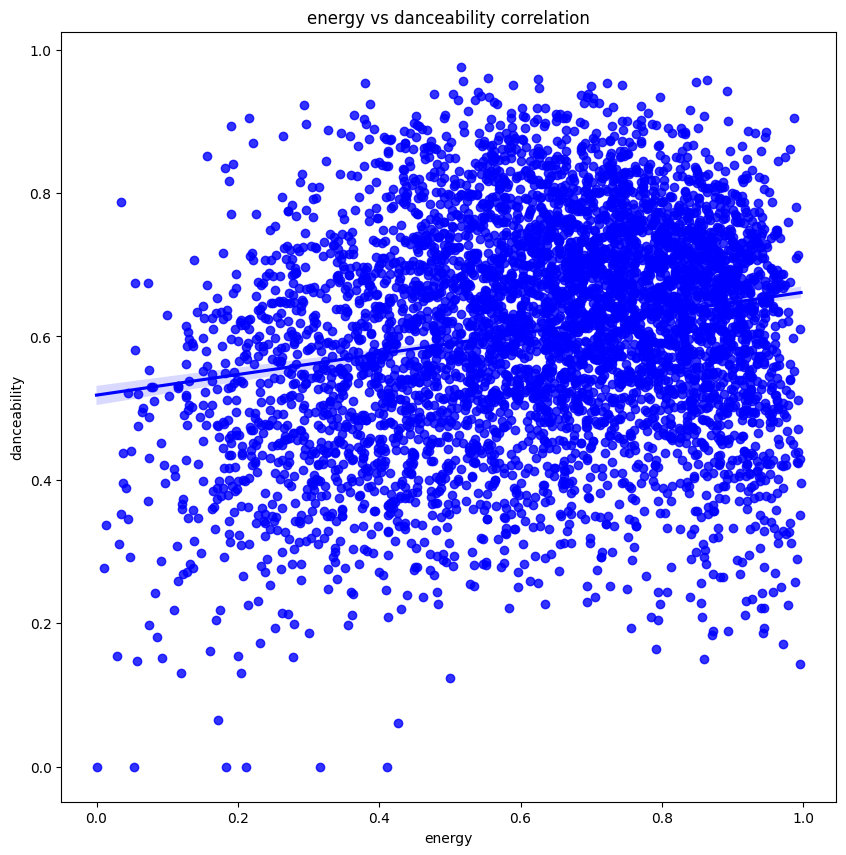

In [16]:
plt.figure(figsize=(10,10))
sns.regplot(data = filtered_track_df, y = "danceability", x= "energy", color = "b").set(title = "energy vs danceability correlation")

The behaviour of the regression line is in **upward direction** which denotes that as the energy of the song increases, the danceability also increases.

Lets plot the heatmap to understand the correlation between different properties of a song.

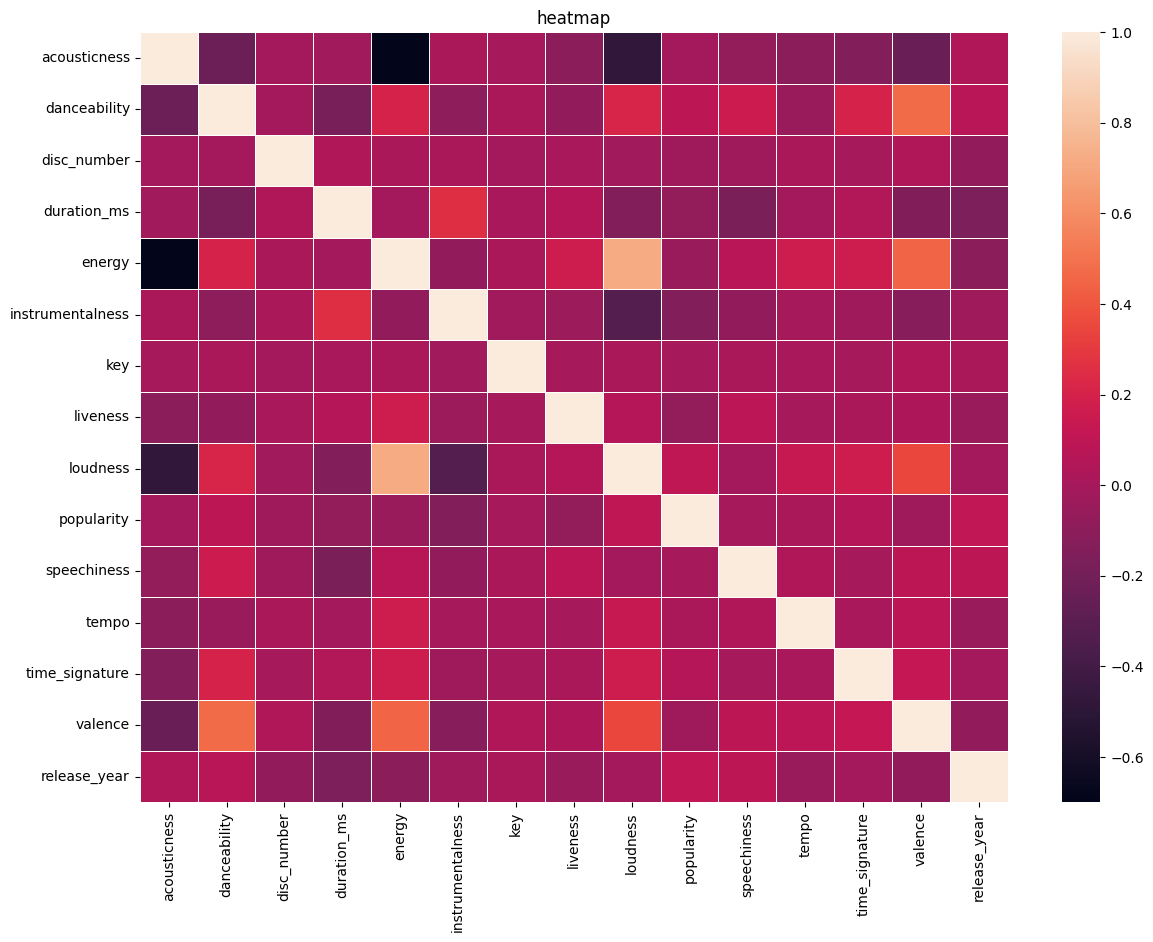

In [17]:
heatmap_df = filtered_track_df.drop(['mode', 'artists_id', 'href', 'id', 'lyrics', 'name', 'playlist', 'preview_url', 'track_href', 'uri', 'artists_name', 'genres', 'release_date'], axis = 1).corr(method ="pearson")
plt.figure(figsize=(14,10))
heatmap = sns.heatmap(heatmap_df, linewidth=0.5)
heatmap.set_title("heatmap")
plt.show()

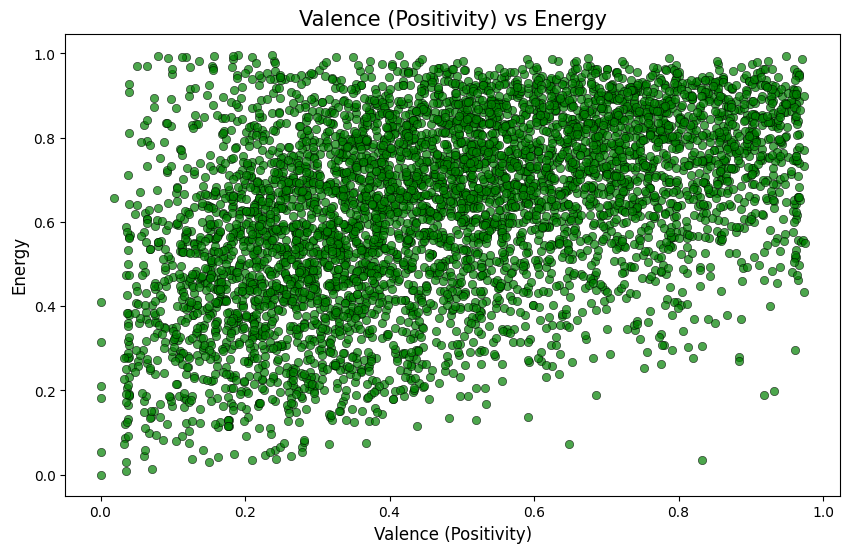

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='valence', y='energy', data=filtered_track_df, color='green', edgecolor='black', alpha=0.7)

plt.title('Valence (Positivity) vs Energy', fontsize=15)
plt.xlabel('Valence (Positivity)', fontsize=12)
plt.ylabel('Energy', fontsize=12)

plt.show()

/var/folders/9m/c81hxzzn101dbywczw7zmy480000gn/T/ipykernel_25069/2722998940.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genres', y='danceability', data=filtered_genre_df_plot, palette="Set3")


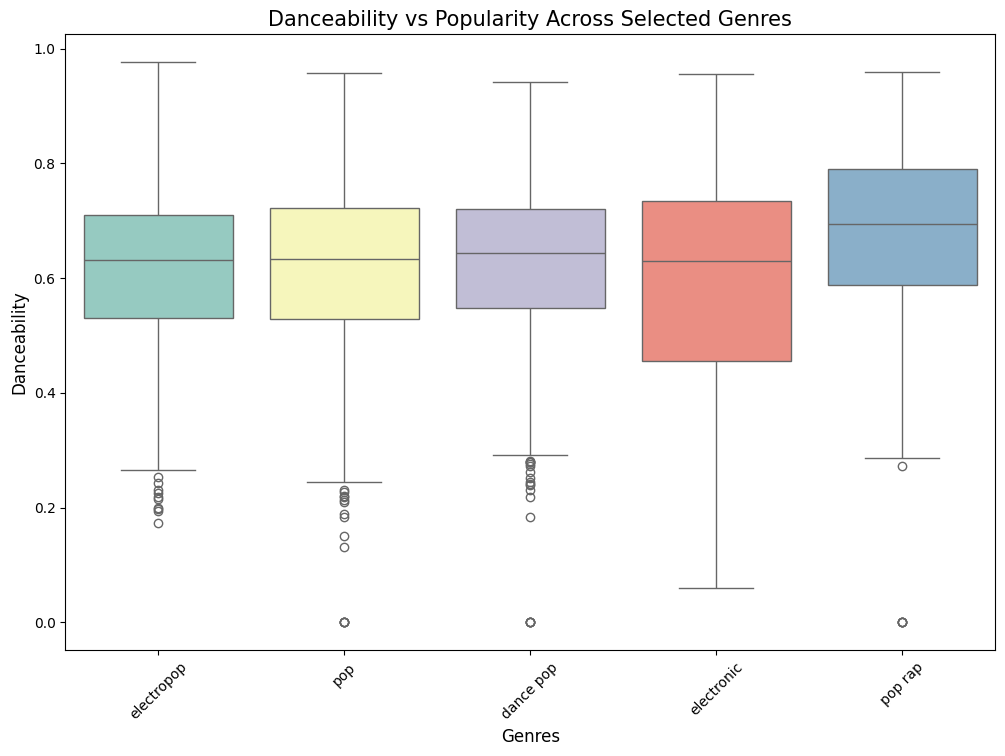

In [19]:
genres_to_include = ['dance pop', 'electronic', 'electropop', 'pop', 'pop rap']
filtered_track_df['genres'] = filtered_track_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Filter the rows that contain any of the genres in the 'genres_to_include' list
filtered_genre_df = filtered_track_df[filtered_track_df['genres'].apply(lambda x: any(genre in genres_to_include for genre in x))]

# Explode the genres list so each genre gets its own row
filtered_genre_df_exploded = filtered_genre_df.explode('genres')

# Filter again to ensure only genres in the list are included
filtered_genre_df_plot = filtered_genre_df_exploded[filtered_genre_df_exploded['genres'].isin(genres_to_include)]

# Check if the filtered DataFrame is empty
if filtered_genre_df_plot.empty:
    print("The filtered DataFrame is empty.")
else:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='genres', y='danceability', data=filtered_genre_df_plot, palette="Set3")

    plt.title('Danceability vs Popularity Across Selected Genres', fontsize=15)
    plt.xlabel('Genres', fontsize=12)
    plt.ylabel('Danceability', fontsize=12)
    plt.xticks(rotation=45)  # Rotate genre labels for better readability

    plt.show()

In [20]:
print(filtered_track_df['genres'].dtype)

object


In [21]:
filtered_track_df = pd.read_csv("spotify_final_data.csv")

In [22]:
# Load the dataset

songs_df = pd.read_csv("spotify_final_data.csv")

In [23]:
songs_df.describe()

,acousticness,danceability,disc_number,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,release_year
count,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000,5235.000000
mean,0.288523,0.608873,1.020821,225710.761796,0.632617,0.055268,5.217383,0.184137,-6.757434,0.644126,52.842980,0.081828,119.944166,3.938682,0.480674,2016.008214
std,0.299763,0.152527,0.217996,58289.784845,0.212367,0.183848,3.565497,0.157147,3.181013,0.478823,13.502508,0.088101,28.729734,0.364481,0.238470,2.514028
min,0.000000,0.000000,1.000000,3500.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2010.000000
25%,0.032250,0.510000,1.000000,194232.000000,0.483000,0.000000,2.000000,0.097300,-8.204000,0.000000,44.000000,0.035500,97.135500,4.000000,0.288000,2014.000000
50%,0.164000,0.622000,1.000000,217760.000000,0.661000,0.000002,5.000000,0.122000,-6.152000,1.000000,54.000000,0.048700,119.979000,4.000000,0.464000,2017.000000
75%,0.500000,0.717500,1.000000,245867.000000,0.805000,0.000504,8.000000,0.212000,-4.656000,1.000000,62.000000,0.083900,137.961000,4.000000,0.667000,2018.000000
max,0.995000,0.976000,9.000000,944613.000000,0.997000,0.984000,11.000000,0.989000,-0.330000,1.000000,97.000000,0.941000,209.474000,5.000000,0.975000,2019.000000


In [24]:
songs_df.columns

Index(['artists_id', 'acousticness', 'danceability', 'disc_number',
       'duration_ms', 'energy', 'href', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'lyrics', 'mode', 'name', 'playlist',
       'popularity', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'uri', 'valence', 'release_date', 'artists_name',
       'genres', 'release_year'],
      dtype='object')

In [25]:
filtered_songs = songs_df[songs_df['release_year'] >= 2015]

filtered_songs.to_csv('filtered_songs.csv', index=False)
filtered_songs_df = pd.read_csv("filtered_songs.csv")


# count of filtered songs 
len(filtered_songs_df)

3879

In [26]:
cols_to_drop = ["artists_id","disc_number","duration_ms","playlist","preview_url","time_signature"]
df = filtered_songs_df.drop(cols_to_drop, axis=1)

In [27]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
            'key', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

In [28]:
# Define the path to the My_Liked_songs CSV file
csv_path = "My_liked_songs_with_features.csv"

# Read the first 5 rows of the CSV file and extract the specified columns
df2 = pd.read_csv(csv_path, usecols=features, nrows=5)

# Convert the DataFrame to a NumPy array
features_array = df2.values

# Print the resulting array
print(features_array)

[[ 5.73000e-01  4.22000e-01  1.00000e+01 -7.62100e+00  6.78000e-02
   5.51000e-01  1.31000e-05  1.02000e-01  6.93000e-01  1.24357e+02]
 [ 4.72000e-01  6.71000e-01  4.00000e+00 -4.64900e+00  2.90000e-02
   1.29000e-02  0.00000e+00  1.59000e-01  6.81000e-02  8.29520e+01]
 [ 3.86000e-01  9.17000e-01  1.10000e+01 -8.08900e+00  1.03000e-01
   2.85000e-02  8.97000e-01  8.78000e-01  5.68000e-01  1.27315e+02]
 [ 5.85000e-01  6.73000e-01  2.00000e+00 -8.27400e+00  3.42000e-02
   6.20000e-04  2.84000e-01  2.05000e-01  3.89000e-02  1.20015e+02]
 [ 3.72000e-01  7.76000e-01  0.00000e+00 -6.97400e+00  5.21000e-02
   4.88000e-03  8.66000e-01  2.95000e-01  5.04000e-01  1.75090e+02]]


In [29]:
df2=df2.assign(list="MyList")

In [30]:
display(df2)

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,list
0,0.573,0.422,10,-7.621,0.0678,0.55100,0.000013,0.102,0.6930,124.357,MyList
1,0.472,0.671,4,-4.649,0.0290,0.01290,0.000000,0.159,0.0681,82.952,MyList
2,0.386,0.917,11,-8.089,0.1030,0.02850,0.897000,0.878,0.5680,127.315,MyList
3,0.585,0.673,2,-8.274,0.0342,0.00062,0.284000,0.205,0.0389,120.015,MyList
4,0.372,0.776,0,-6.974,0.0521,0.00488,0.866000,0.295,0.5040,175.090,MyList


In [31]:
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

# Train the KNN model
k = 2
knn = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
knn.fit(X, df['name'])


def model(input_song):
    
    # Normalize the input song
    X_input = scaler.transform([input_song])

    # Find the k-nearest neighbors
    distances, indices = knn.kneighbors(X_input)

    # Recommend songs based on the k-nearest neighbors
    recommended_songs = df.loc[indices[0], ['name', 'artists_name', 'id', 'acousticness', 'danceability',
                                            'energy', 'instrumentalness', 'key', 'liveness', 'loudness',
                                            'popularity', 'speechiness', 'tempo','valence', 'genres']]
    
    return recommended_songs


In [32]:
all_recommendations = pd.DataFrame()

In [33]:
all_recommendations = pd.DataFrame()

for song in features_array:
    recommendations = model(song)
    all_recommendations = pd.concat([all_recommendations, recommendations], ignore_index=True)

print(all_recommendations)

                  name       artists_name                      id  \
0       Tipo de Garota          Lia Clark  6ogAWwedaoQOzDajUrJzl0   
1      Dale Vieja Dale       Toño Rosario  734vYzX6YKgSDHzXuLQJmg   
2             Pescaíto       Carlos Vives  2ztbVmIpLxX8fHPZi2U278   
3                Devil       SUPER JUNIOR  3IQ9FJ2cMVQtger5ZhgCaj   
4      Dale Vieja Dale       Toño Rosario  734vYzX6YKgSDHzXuLQJmg   
5        Alucinaciones  Silvestre Dangond  3uS20fOdtkDSy7fOH2kTYh   
6      Muchachita Loca      Teodoro Reyes  57CWpsz0FVL59GbluT69Dm   
7                Devil       SUPER JUNIOR  3IQ9FJ2cMVQtger5ZhgCaj   
8      Muchachita Loca      Teodoro Reyes  57CWpsz0FVL59GbluT69Dm   
9  Roll (Burbank Funk)       The Internet  01bfHCsUTwydXCHP1VoLlI   

   acousticness  danceability  energy  instrumentalness   key  liveness  \
0        0.2690         0.699   0.949          0.000160  10.0    0.1370   
1        0.5270         0.648   0.951          0.000000   7.0    0.0707   
2        0.0270

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have va

In [34]:
all_recommendations=all_recommendations.assign(list="Recommended")

In [35]:
all_recommendations.columns

Index(['name', 'artists_name', 'id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'popularity',
       'speechiness', 'tempo', 'valence', 'genres', 'list'],
      dtype='object')

In [36]:
cols_to_drop = ['name', 'artists_name', 'id', 'genres','popularity']
rec_df = all_recommendations.drop(cols_to_drop, axis=1)

In [37]:
rec_df = rec_df[['list','acousticness', 'danceability','key', 'energy',  'loudness', 'speechiness',
        'instrumentalness', 'liveness', 'valence', 'tempo']]

df2 = df2[['list','acousticness', 'danceability','key', 'energy',  'loudness', 'speechiness',
        'instrumentalness', 'liveness', 'valence', 'tempo']]

In [38]:
final_df = pd.concat([df2, rec_df], ignore_index=True)

display(final_df)

,list,acousticness,danceability,key,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo
0,MyList,0.55100,0.573,10.0,0.422,-7.621,0.0678,0.000013,0.1020,0.6930,124.357
1,MyList,0.01290,0.472,4.0,0.671,-4.649,0.0290,0.000000,0.1590,0.0681,82.952
2,MyList,0.02850,0.386,11.0,0.917,-8.089,0.1030,0.897000,0.8780,0.5680,127.315
3,MyList,0.00062,0.585,2.0,0.673,-8.274,0.0342,0.284000,0.2050,0.0389,120.015
4,MyList,0.00488,0.372,0.0,0.776,-6.974,0.0521,0.866000,0.2950,0.5040,175.090
5,Recommended,0.26900,0.699,10.0,0.949,-3.092,0.0421,0.000160,0.1370,0.9670,160.021
6,Recommended,0.52700,0.648,7.0,0.951,-1.565,0.2330,0.000000,0.0707,0.9660,165.364
7,Recommended,0.02700,0.687,7.0,0.888,-5.102,0.0756,0.000000,0.0505,0.9660,114.987
8,Recommended,0.13300,0.773,4.0,0.865,-3.027,0.1140,0.000000,0.0520,0.9680,145.003
9,Recommended,0.52700,0.648,7.0,0.951,-1.565,0.2330,0.000000,0.0707,0.9660,165.364


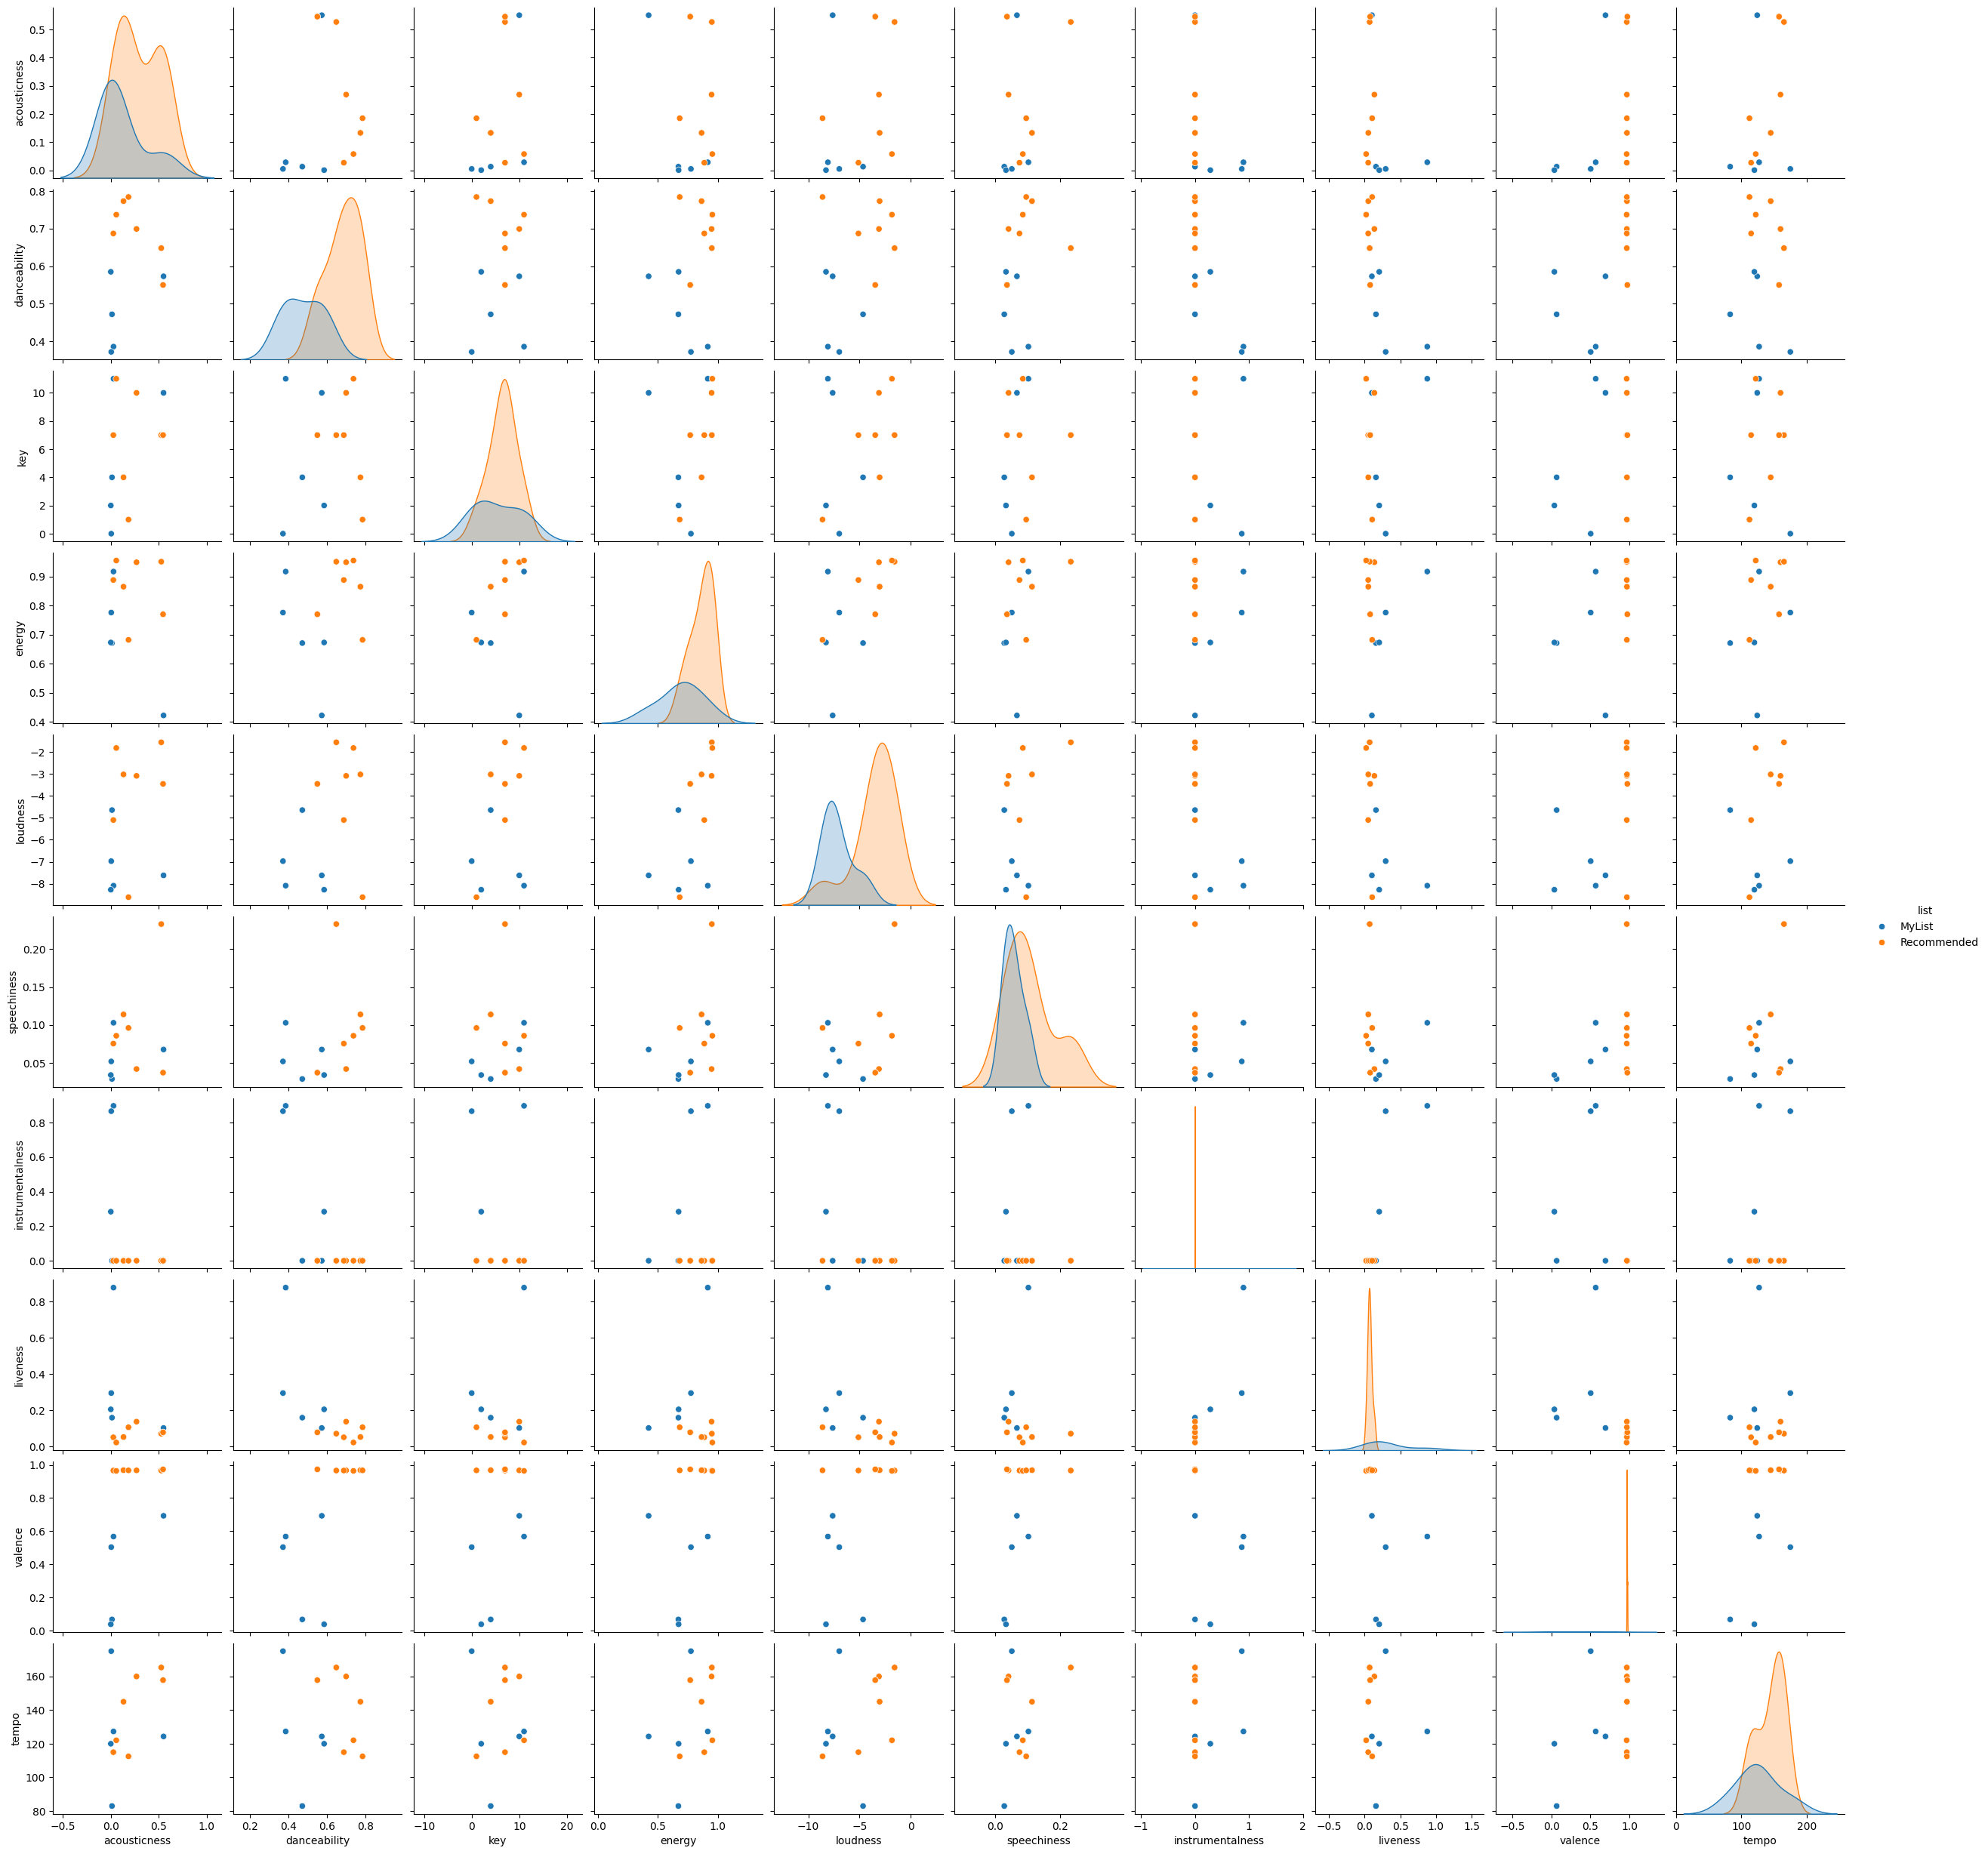

In [39]:
import pprint as pp
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

music_pairplot = sns.pairplot(final_df, hue='list')
music_pairplot

/var/folders/9m/c81hxzzn101dbywczw7zmy480000gn/T/ipykernel_25069/144213407.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(final_df.loc[final_df['list'] == 'MyList', col], shade=True, label='MyList')
/var/folders/9m/c81hxzzn101dbywczw7zmy480000gn/T/ipykernel_25069/144213407.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(final_df.loc[final_df['list'] == 'Recommended', col], shade=True, label='Recommended')
/var/folders/9m/c81hxzzn101dbywczw7zmy480000gn/T/ipykernel_25069/144213407.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(final_df.loc[final_df['list'] == 'MyList', col], shade=True, label='MyList')
/var/f

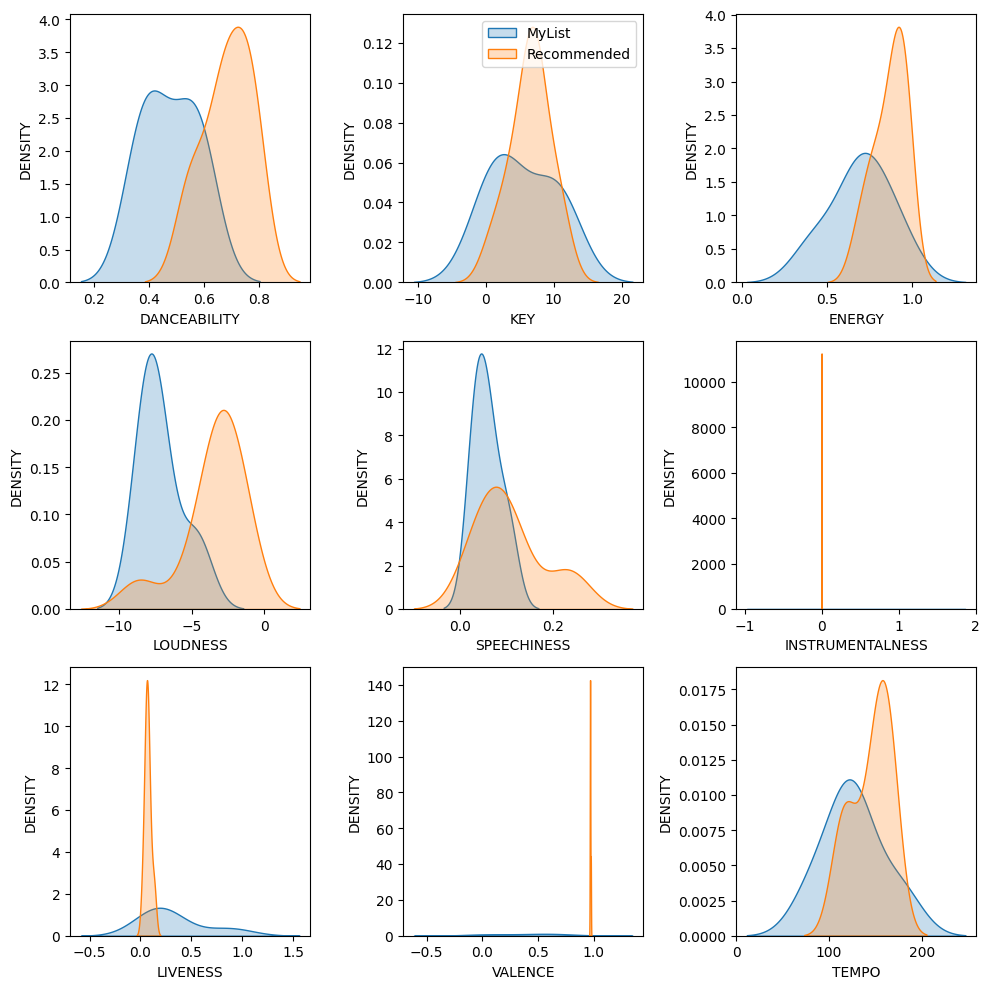

In [40]:
plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(final_df.columns[2:]): #change this first
    plt.subplot(3, 3, i+1)
    sns.kdeplot(final_df.loc[final_df['list'] == 'MyList', col], shade=True, label='MyList')
    sns.kdeplot(final_df.loc[final_df['list'] == 'Recommended', col], shade=True, label='Recommended')

    plt.ylabel('DENSITY')

    plt.xlabel(col.upper())

    if i == 1:
        plt.legend(loc='upper right')
    else:
        plt.legend().remove()

plt.tight_layout()

# the x-axis in kde is range of values in dataset
# the y-axis is the kernel density estimate.

# Inference

Visualisation is important because using graphs is much easier and quicker to analyse than numerical data. From the above seaborn plot we can infer that the when we find the nearest neighbor for all the features of a liked song, the distributions do not comapare well for most features. Meaning, if we try to find the nearest neighbors to a particular song then only one or a select few features match closely to the features of the already liked songs. Inversely, if we try to match more number of features, the distance increases from our original liked songs.

<br />
<center>
<img src="catdj.gif" width=400 />
</center>

So for us to run a successful dj company we need to be able to recognize the priority. For this project we will group all songs into the main genres so that as a dj we can select one or two genres according to the crowd and find the nearest matches to the song (to reduce the distance by reducing the no of features to match to)

original_df = pd.DataFrame()
original_df.to_csv("After_cols_Drop.csv", index=False)

In [41]:
filtered_track_df = pd.read_csv("spotify_final_data.csv")


spotify_genres = ['jazz', 'latin', 'pop', 'r&b', 'hip-hop', 'rock', 'indie', 'mellow', 'rap', 'soul', 'contemporary', 'country', 'folk']


def identifygenre(genres):
       for x in genres:
            for item2 in spotify_genres:
                if x in item2:
                    return item2

filtered_track_df['genres'] = filtered_track_df['genres'].apply(identifygenre)

filtered_track_df.head(10)


,artists_id,acousticness,danceability,disc_number,duration_ms,energy,href,id,instrumentalness,key,...,speechiness,tempo,time_signature,track_href,uri,valence,release_date,artists_name,genres,release_year
0,68WwJXWrpo1yVOOIZjLSeT,0.026800,0.506,1.0,248777.0,0.741,https://api.spotify.com/v1/tracks/0UATU9OJxh4m...,0UATU9OJxh4m3fwDljdGZn,0.000027,1.0,...,0.0349,94.042,4.0,https://api.spotify.com/v1/tracks/0UATU9OJxh4m...,0UATU9OJxh4m3fwDljdGZn,0.236,2018-09-28,Evalyn,indie,2018.0
1,6pSsE5y0uJMwYj83KrPyf9,0.133000,0.629,1.0,207396.0,0.706,https://api.spotify.com/v1/tracks/0h7Ld5CvgzaU...,0h7Ld5CvgzaUN1zA3tdyPq,0.000000,1.0,...,0.4360,81.220,4.0,https://api.spotify.com/v1/tracks/0h7Ld5CvgzaU...,0h7Ld5CvgzaUN1zA3tdyPq,0.543,2019-01-25,Dawn Richard,jazz,2019.0
2,1Ffb6ejR6Fe5IamqA5oRUF,0.000123,0.409,1.0,275013.0,0.859,https://api.spotify.com/v1/tracks/6r7bDk4J0Okw...,6r7bDk4J0Okw4ezTBUQXo3,0.000000,10.0,...,0.0367,154.023,4.0,https://api.spotify.com/v1/tracks/6r7bDk4J0Okw...,6r7bDk4J0Okw4ezTBUQXo3,0.473,2015-09-11,Bring Me The Horizon,mellow,2015.0
3,7oPftvlwr6VrsViSDV7fJY,0.000046,0.419,1.0,180853.0,0.971,https://api.spotify.com/v1/tracks/3oqYMRKQcwyN...,3oqYMRKQcwyNmFn1VD2ukD,0.000014,7.0,...,0.0909,180.033,4.0,https://api.spotify.com/v1/tracks/3oqYMRKQcwyN...,3oqYMRKQcwyNmFn1VD2ukD,0.677,2016-10-07,Green Day,pop,2016.0
4,3DiDSECUqqY1AuBP8qtaIa,0.569000,0.616,1.0,231667.0,0.446,https://api.spotify.com/v1/tracks/2iejTMy9XZ8G...,2iejTMy9XZ8Gaae0aQ2yl0,0.000008,7.0,...,0.1090,118.539,3.0,https://api.spotify.com/v1/tracks/2iejTMy9XZ8G...,2iejTMy9XZ8Gaae0aQ2yl0,0.197,2019-02-08,Alicia Keys,hip-hop,2019.0
5,0EmeFodog0BfCgMzAIvKQp,0.011600,0.710,1.0,183947.0,0.871,https://api.spotify.com/v1/tracks/63Tl9k1sH8tz...,63Tl9k1sH8tznn3bqoMuyF,0.000003,9.0,...,0.0503,126.957,4.0,https://api.spotify.com/v1/tracks/63Tl9k1sH8tz...,63Tl9k1sH8tznn3bqoMuyF,0.829,2010-10-19,Shakira,rock,2010.0
6,4obzFoKoKRHIphyHzJ35G3,0.116000,0.786,1.0,208240.0,0.700,https://api.spotify.com/v1/tracks/28r9sD2b6Flu...,28r9sD2b6FluK7YHjTJ0fl,0.000204,5.0,...,0.0590,109.021,4.0,https://api.spotify.com/v1/tracks/28r9sD2b6Flu...,28r9sD2b6FluK7YHjTJ0fl,0.650,2015-08-21,Becky G,latin,2015.0
7,4obzFoKoKRHIphyHzJ35G3,0.059900,0.724,1.0,203080.0,0.755,https://api.spotify.com/v1/tracks/1xuy0LhOqyRE...,1xuy0LhOqyRErM3PTjQfHm,0.000000,8.0,...,0.3120,99.595,4.0,https://api.spotify.com/v1/tracks/1xuy0LhOqyRE...,1xuy0LhOqyRErM3PTjQfHm,0.589,2013-04-23,Becky G,latin,2013.0
8,4obzFoKoKRHIphyHzJ35G3,0.354000,0.427,1.0,200347.0,0.508,https://api.spotify.com/v1/tracks/4xVeiS18oLal...,4xVeiS18oLalSFnqRbuWwx,0.000026,8.0,...,0.1810,78.450,4.0,https://api.spotify.com/v1/tracks/4xVeiS18oLal...,4xVeiS18oLalSFnqRbuWwx,0.308,2015-10-30,Becky G,latin,2015.0
9,4obzFoKoKRHIphyHzJ35G3,0.157000,0.740,1.0,189800.0,0.798,https://api.spotify.com/v1/tracks/7pBBypRRRhCl...,7pBBypRRRhCloyONPGldCG,0.010600,8.0,...,0.0609,104.008,4.0,https://api.spotify.com/v1/tracks/7pBBypRRRhCl...,7pBBypRRRhCloyONPGldCG,0.348,2013-07-16,Becky G,latin,2013.0


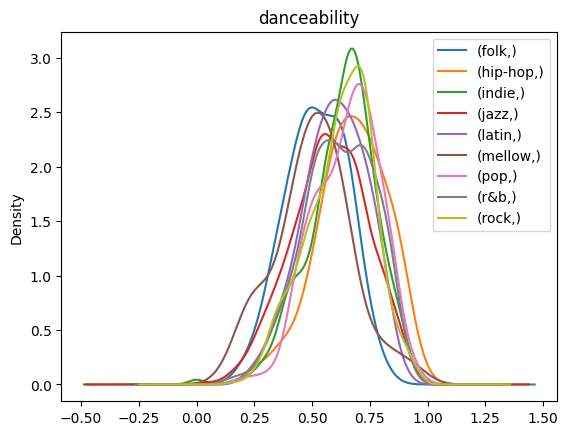

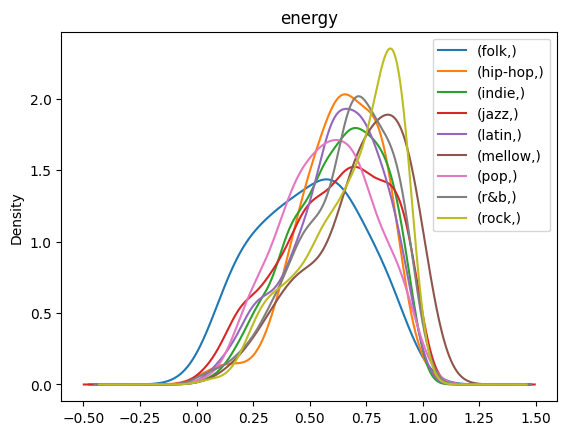

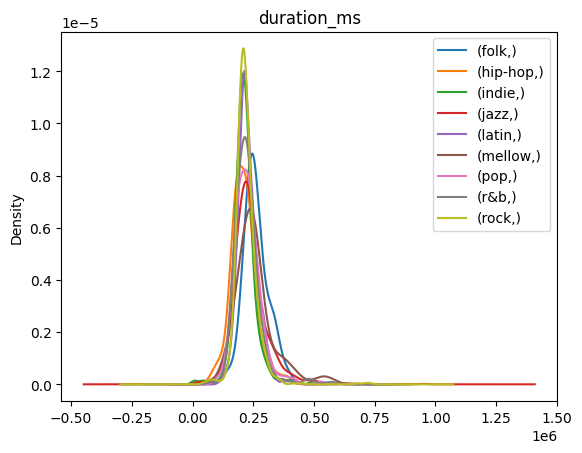

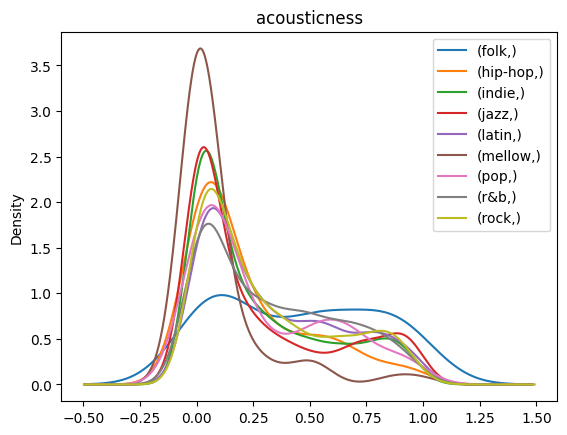

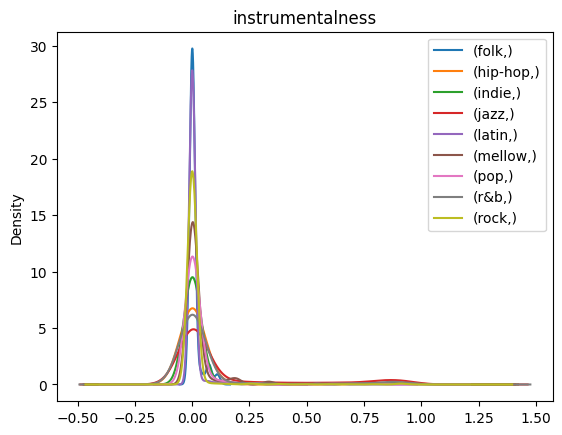

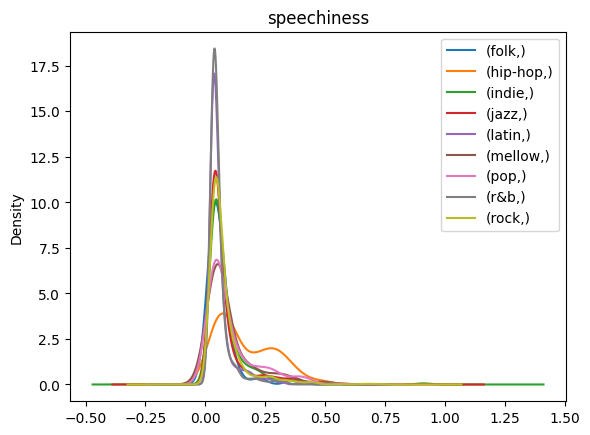

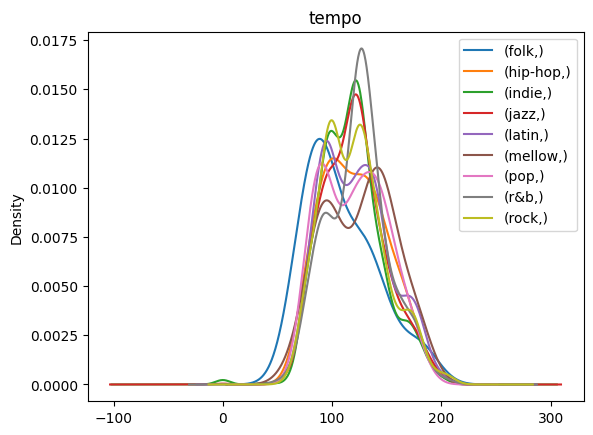

In [42]:
grouped = filtered_track_df.groupby(by = ["genres"])



for prop in ['danceability', 'energy', 'duration_ms', 'acousticness', 'instrumentalness', 'speechiness', 'tempo']:
    fig, ax = plt.subplots()
    for name, group in grouped:
        #group[prop].plot(kind='hist', alpha=0.5, label=name, density=False, ax=ax)
        group[prop].plot(kind='density', label=name, ax=ax)
    #grouped.size().plot(kind='pie', labels=grouped.groups.keys(), autopct='%1.1f%%', ax=ax)
    ax.set_title(prop)
    ax.legend()
    plt.show()

#plt.show()

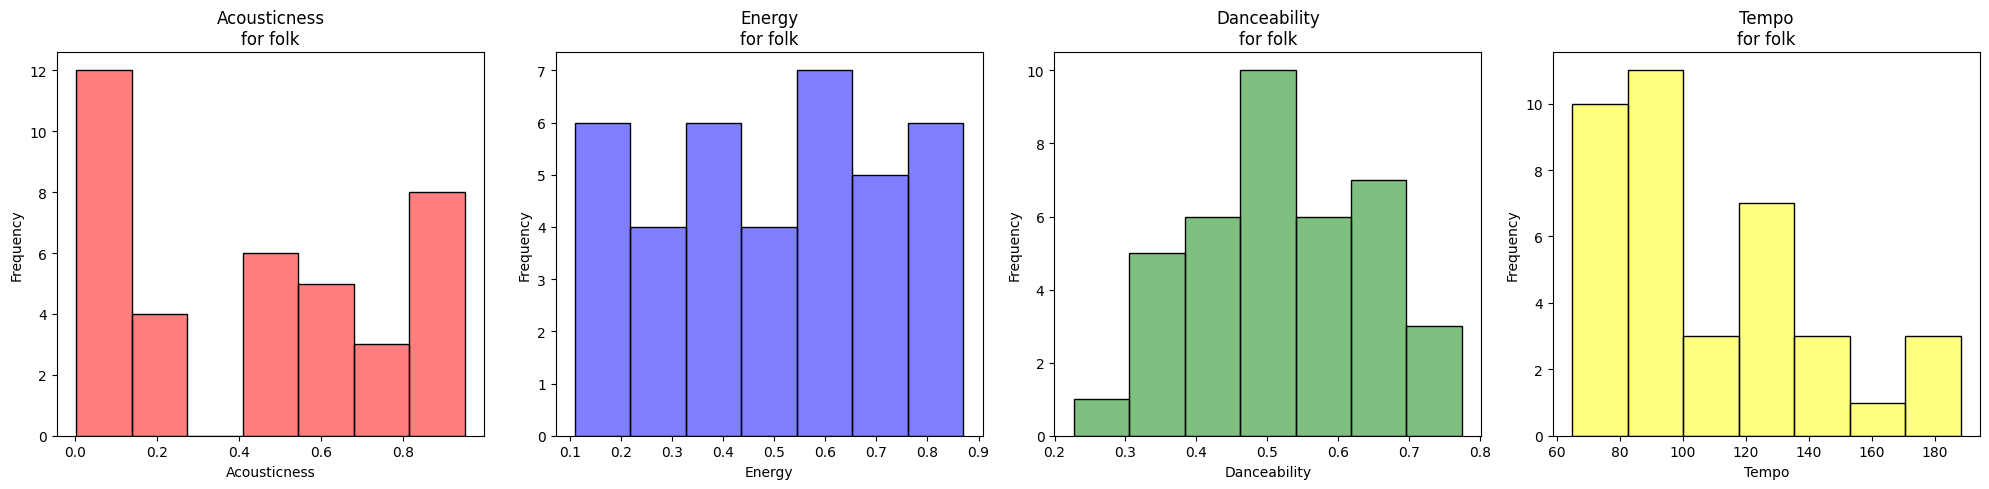

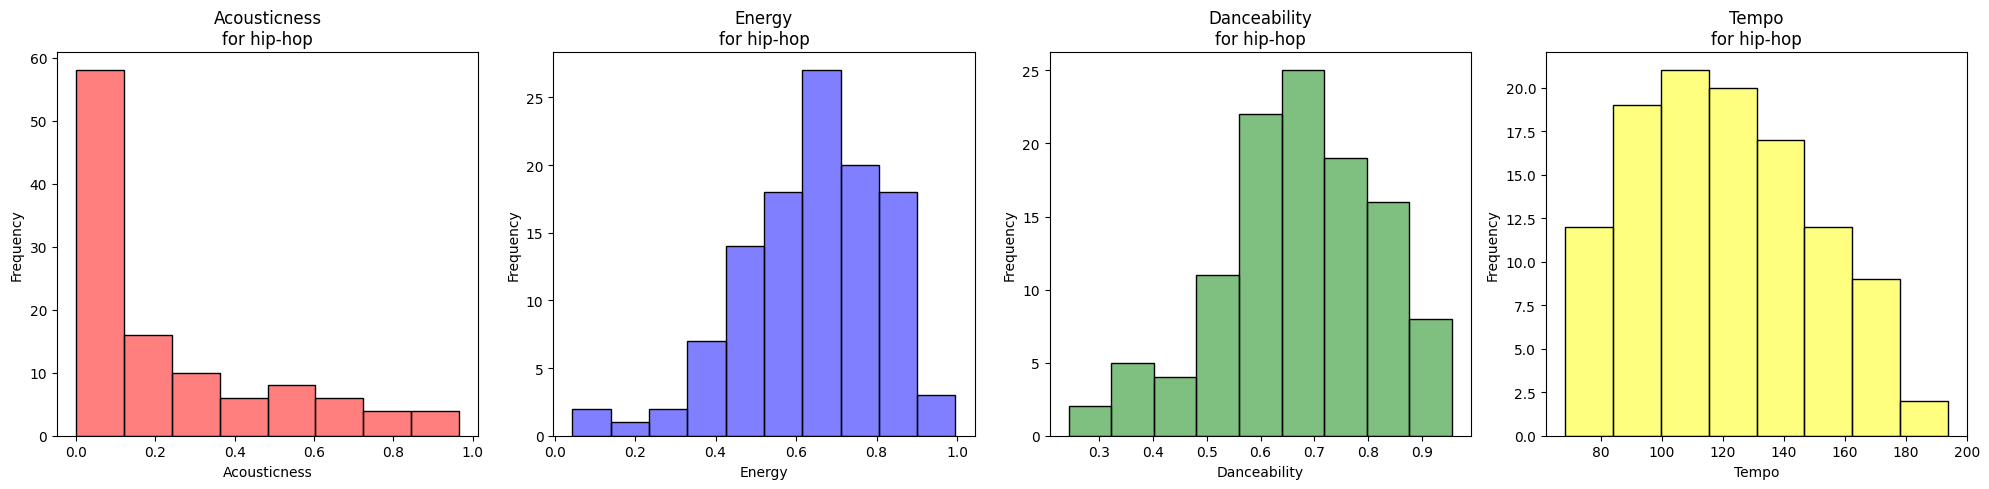

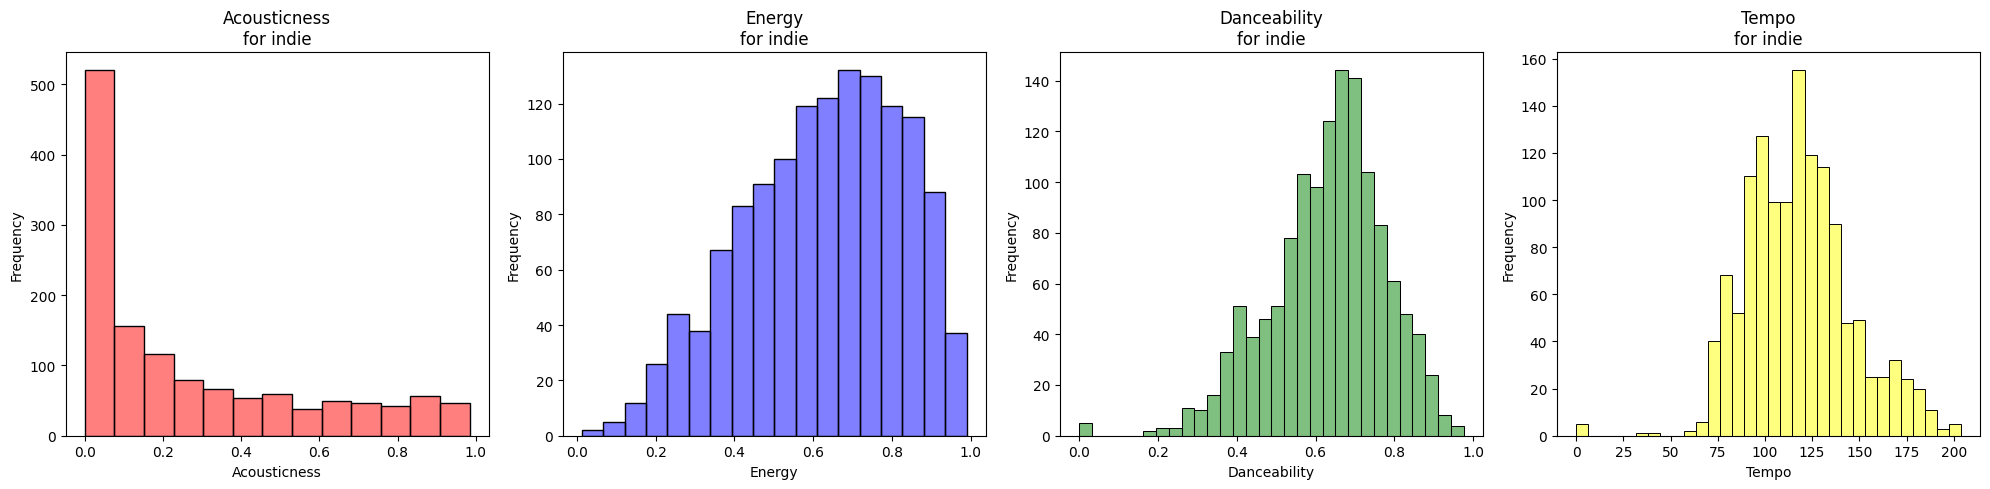

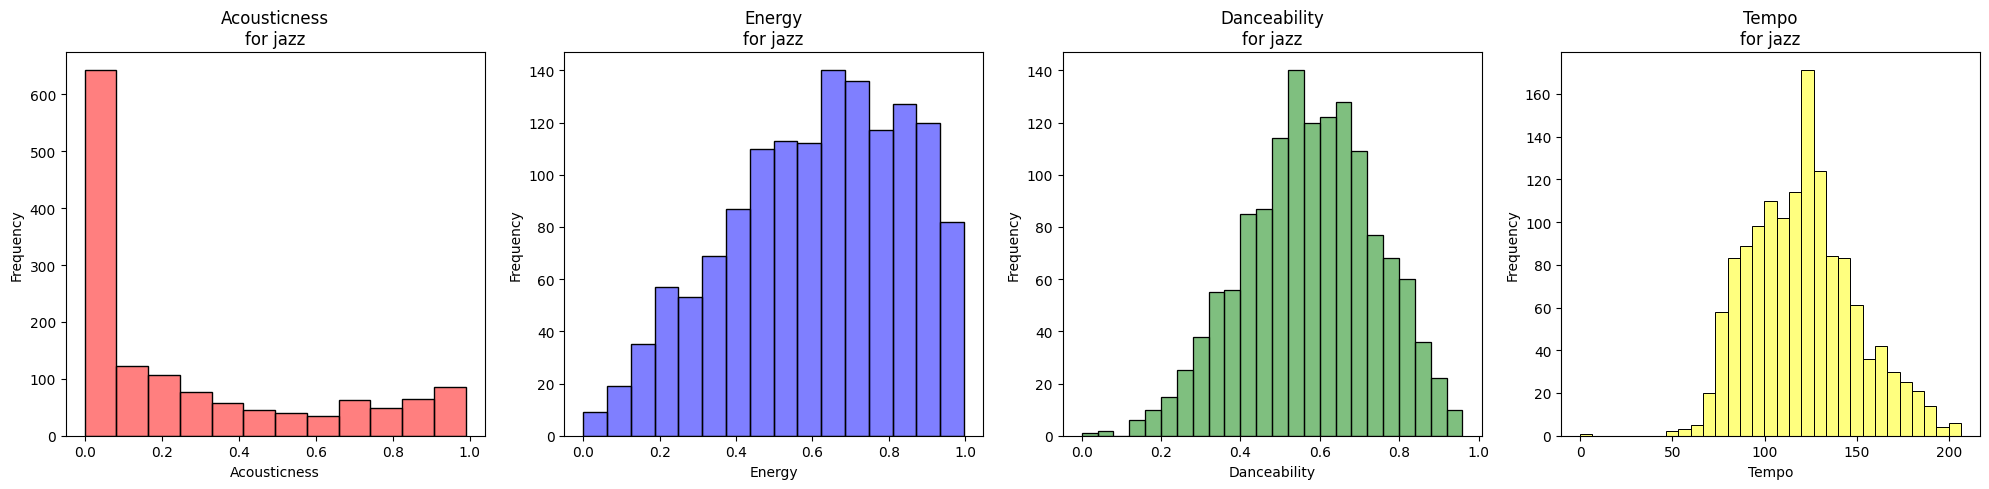

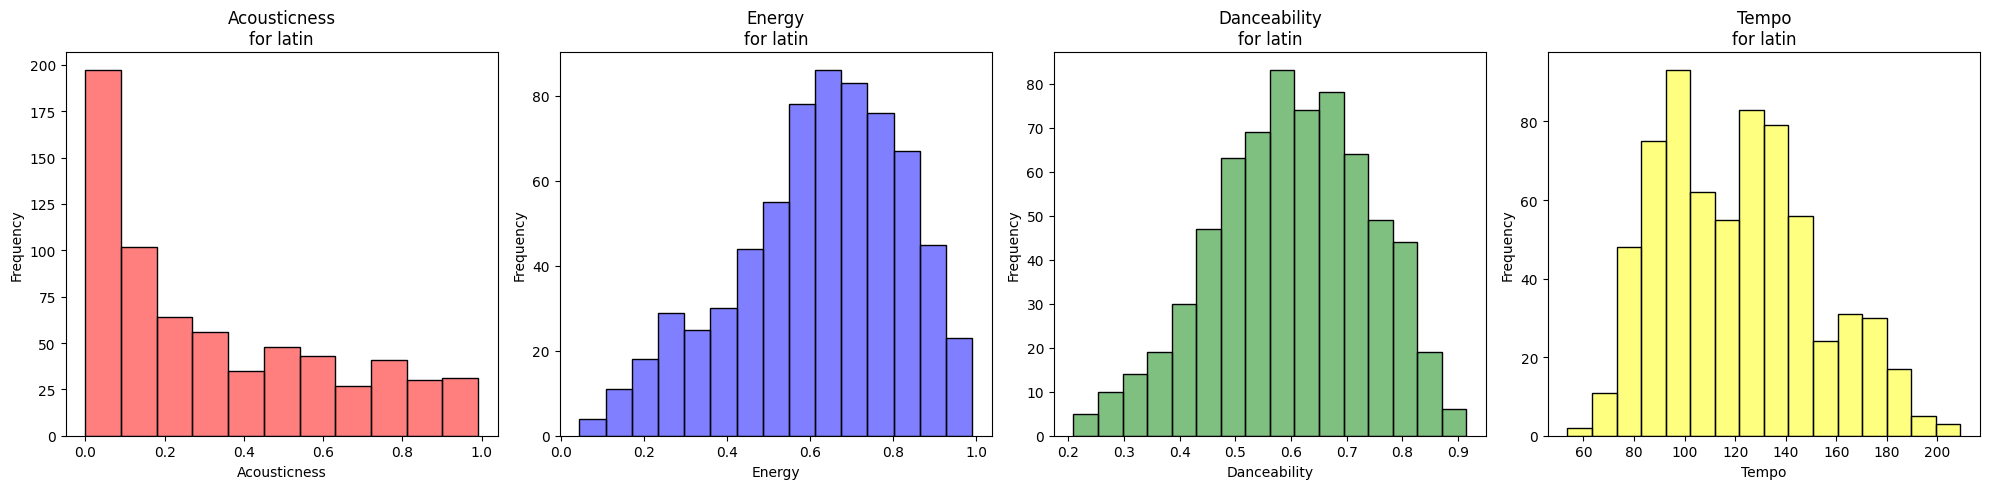

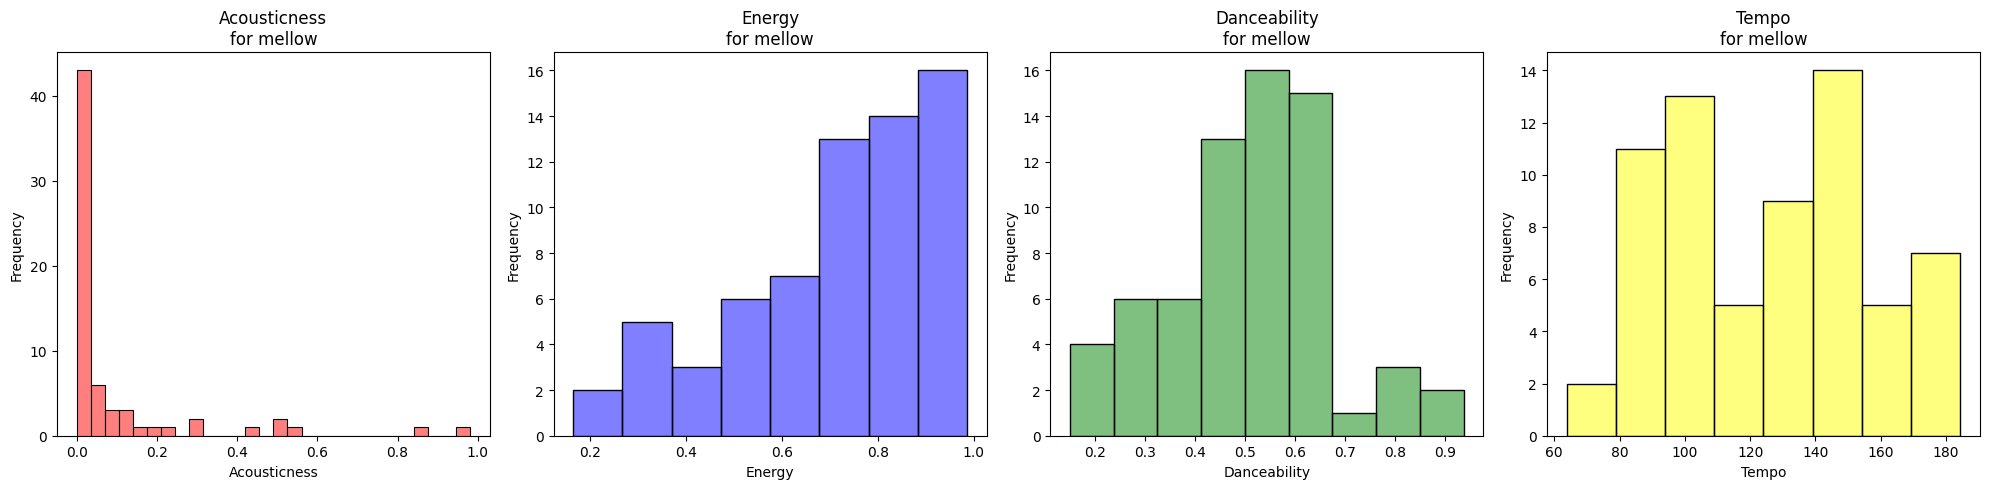

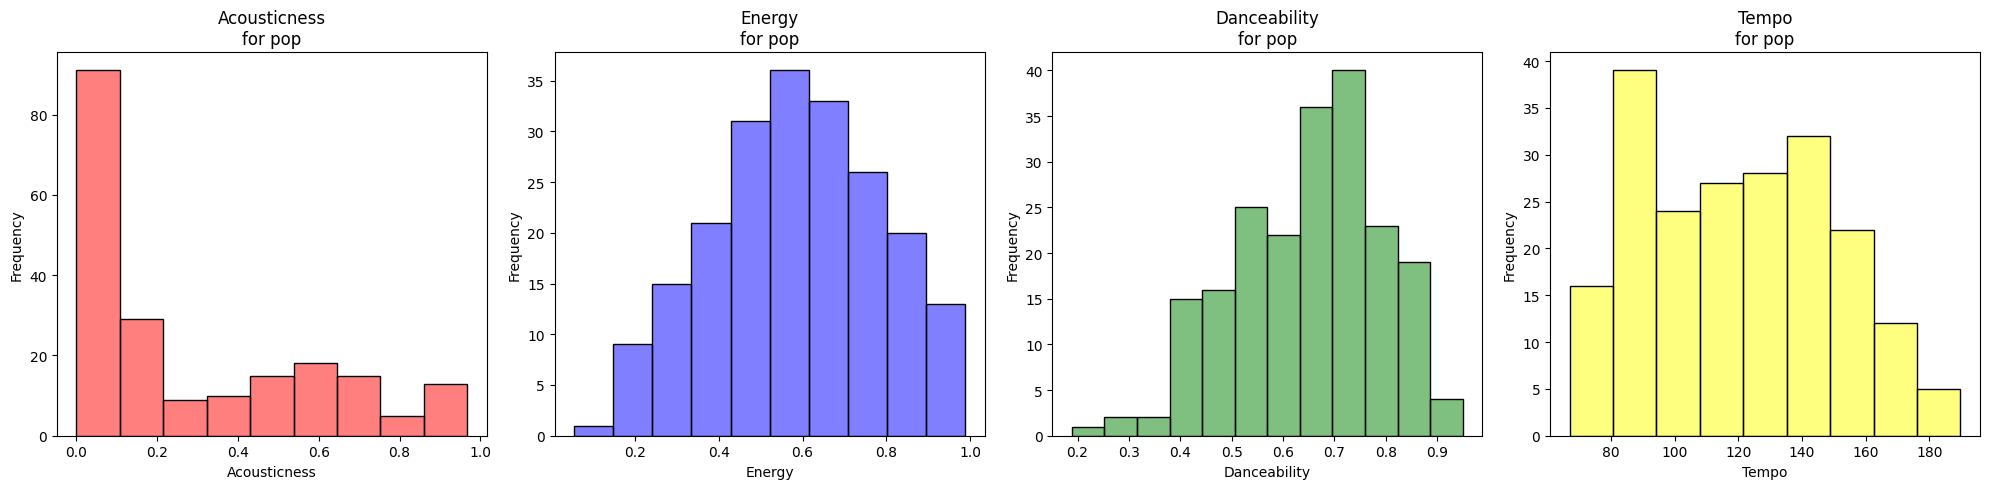

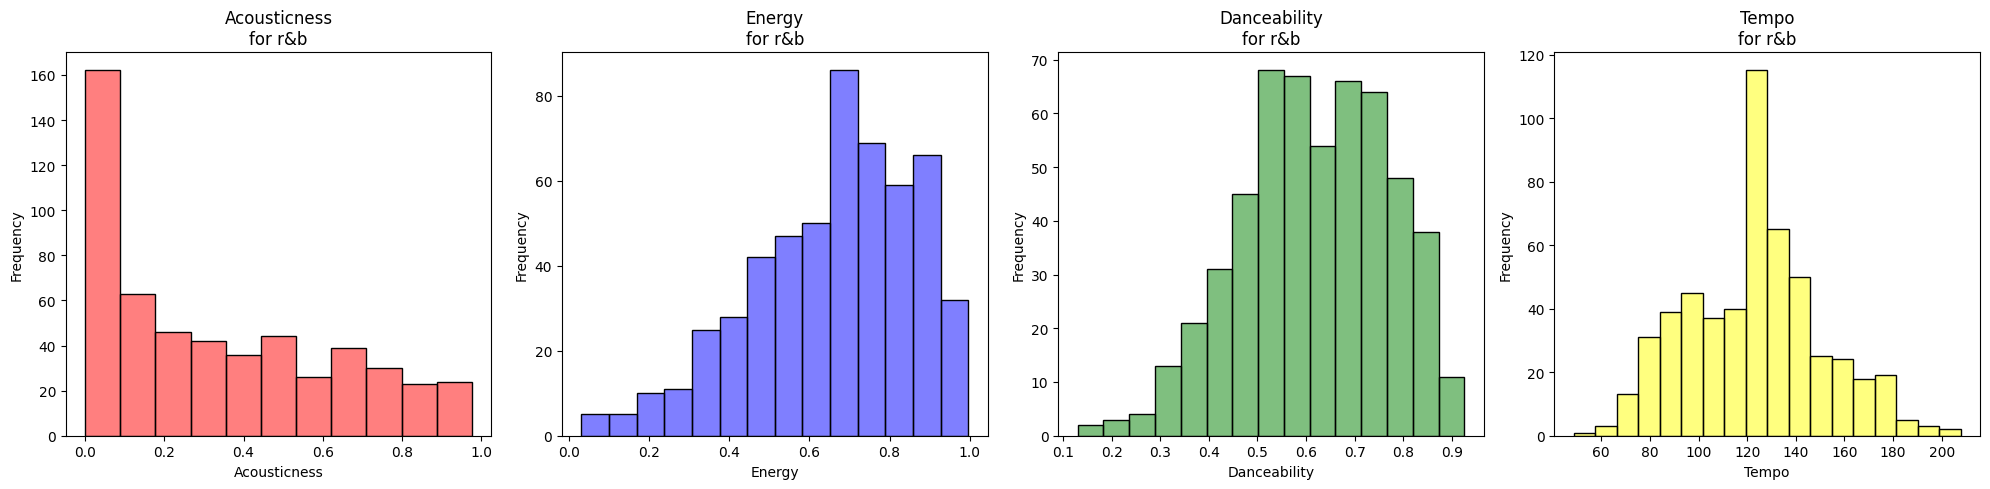

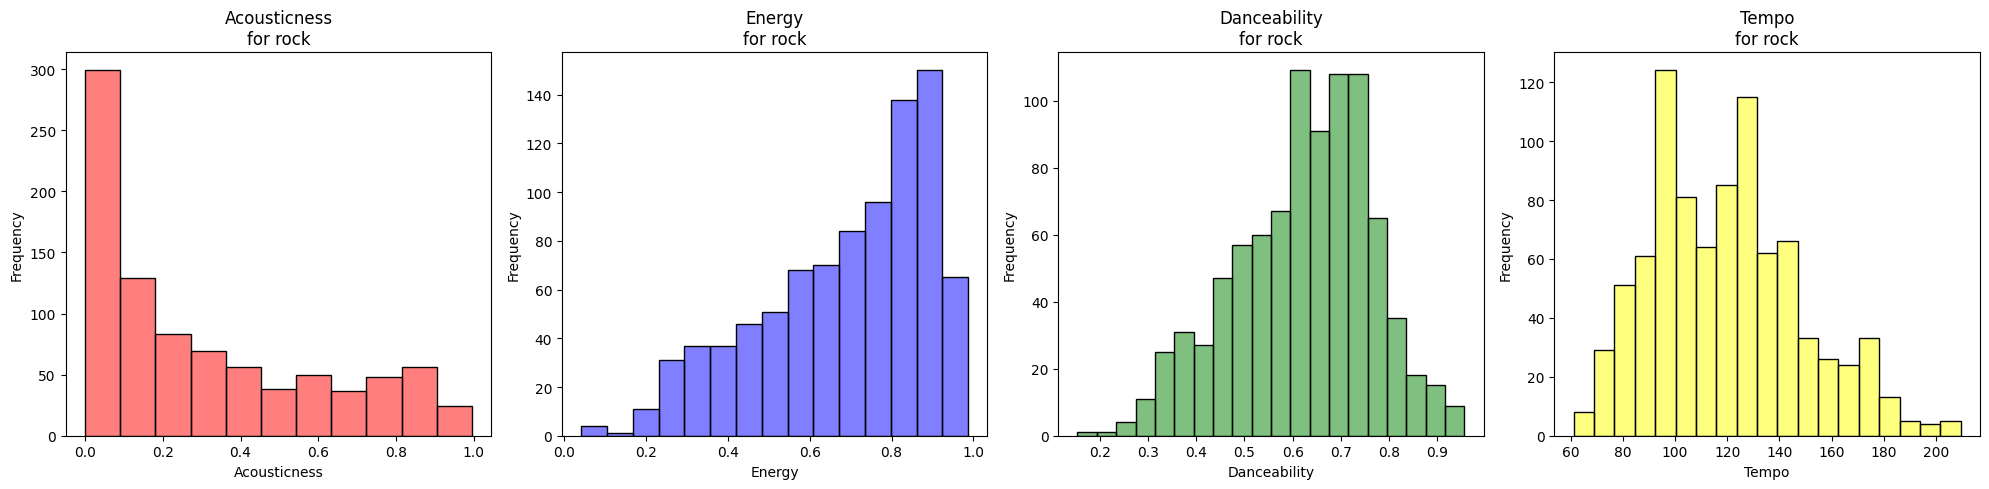

In [43]:
grouped = filtered_track_df.groupby('genres')

for genre, group in grouped:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  
    
    sns.histplot(data=group, x='acousticness', color='red', alpha=0.5, ax=axes[0])
    axes[0].set_title('Acousticness\nfor {}'.format(genre))
    axes[0].set_xlabel('Acousticness')
    axes[0].set_ylabel('Frequency')
    
    sns.histplot(data=group, x='energy', color='blue', alpha=0.5, ax=axes[1])
    axes[1].set_title('Energy\nfor {}'.format(genre))
    axes[1].set_xlabel('Energy')
    axes[1].set_ylabel('Frequency')
    
    sns.histplot(data=group, x='danceability', color='green', alpha=0.5, ax=axes[2])
    axes[2].set_title('Danceability\nfor {}'.format(genre))
    axes[2].set_xlabel('Danceability')
    axes[2].set_ylabel('Frequency')
    
    sns.histplot(data=group, x='tempo', color='yellow', alpha=0.5, ax=axes[3])
    axes[3].set_title('Tempo\nfor {}'.format(genre))
    axes[3].set_xlabel('Tempo')
    axes[3].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()


And to become a MAAADDDD DJ and really reduce the distance we can also only use 1 or 2 features - according to the genre our audience prefers as we want the party to be really banging!

<br />
<center>
<img src="catdjdisco.gif" width=400 />
</center>

If we are in a hip hop club, from the graph above we can use speechiness (as it is one feature that is very dissimilar to other genre.)

In [44]:
df_copy = filtered_track_df[filtered_track_df['genres'] == 'hip-hop'].copy()

In [45]:
display(df_copy)

,artists_id,acousticness,danceability,disc_number,duration_ms,energy,href,id,instrumentalness,key,...,speechiness,tempo,time_signature,track_href,uri,valence,release_date,artists_name,genres,release_year
4,3DiDSECUqqY1AuBP8qtaIa,0.5690,0.616,1.0,231667.0,0.446,https://api.spotify.com/v1/tracks/2iejTMy9XZ8G...,2iejTMy9XZ8Gaae0aQ2yl0,0.000008,7.0,...,0.1090,118.539,3.0,https://api.spotify.com/v1/tracks/2iejTMy9XZ8G...,2iejTMy9XZ8Gaae0aQ2yl0,0.197,2019-02-08,Alicia Keys,hip-hop,2019.0
82,1cXi8ALPQCBHZbf0EgP4Ey,0.0132,0.351,1.0,173053.0,0.996,https://api.spotify.com/v1/tracks/0jrMrAKf4LAU...,0jrMrAKf4LAUETxwEJ12U0,0.000000,8.0,...,0.0790,168.868,4.0,https://api.spotify.com/v1/tracks/0jrMrAKf4LAU...,0jrMrAKf4LAUETxwEJ12U0,0.190,2016-06-17,Misfits,hip-hop,2016.0
120,20sxb77xiYeusSH8cVdatc,0.0948,0.683,1.0,189057.0,0.854,https://api.spotify.com/v1/tracks/0hjLM1wMtk27...,0hjLM1wMtk27Qd4ZihyHmi,0.000000,2.0,...,0.1960,92.006,4.0,https://api.spotify.com/v1/tracks/0hjLM1wMtk27...,0hjLM1wMtk27Qd4ZihyHmi,0.131,2017-08-04,Meek Mill,hip-hop,2017.0
129,1gPhS1zisyXr5dHTYZyiMe,0.1050,0.667,1.0,220987.0,0.797,https://api.spotify.com/v1/tracks/7CCb8IeGwXfn...,7CCb8IeGwXfnENvvGnCk9c,0.000000,11.0,...,0.3500,180.015,4.0,https://api.spotify.com/v1/tracks/7CCb8IeGwXfn...,7CCb8IeGwXfnENvvGnCk9c,0.816,2017-09-22,Kevin Gates,hip-hop,2017.0
156,1gPhS1zisyXr5dHTYZyiMe,0.1160,0.568,1.0,173419.0,0.643,https://api.spotify.com/v1/tracks/5DbIxurVkaHT...,5DbIxurVkaHTfrS1BsMj8i,0.000036,5.0,...,0.2790,103.353,5.0,https://api.spotify.com/v1/tracks/5DbIxurVkaHT...,5DbIxurVkaHTfrS1BsMj8i,0.708,2019-01-28,Kevin Gates,hip-hop,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4811,3DiDSECUqqY1AuBP8qtaIa,0.8310,0.244,1.0,373703.0,0.482,https://api.spotify.com/v1/tracks/5qEsQiKndh4h...,5qEsQiKndh4h3d16LiZs5x,0.000023,6.0,...,0.0305,169.658,4.0,https://api.spotify.com/v1/tracks/5qEsQiKndh4h...,5qEsQiKndh4h3d16LiZs5x,0.410,2019-02-11,Alicia Keys,hip-hop,2019.0
4906,5dHt1vcEm9qb8fCyLcB3HL,0.0651,0.797,1.0,173600.0,0.844,https://api.spotify.com/v1/tracks/4dVpf9jZjcOR...,4dVpf9jZjcORqGTLUaeYj9,0.000000,11.0,...,0.2750,170.142,4.0,https://api.spotify.com/v1/tracks/4dVpf9jZjcOR...,4dVpf9jZjcORqGTLUaeYj9,0.520,2017-08-18,A$AP Ferg,hip-hop,2017.0
4915,137W8MRPWKqSmrBGDBFSop,0.0646,0.684,1.0,217667.0,0.834,https://api.spotify.com/v1/tracks/5A6OHHy73AR5...,5A6OHHy73AR5tLxgTc98zz,0.000000,2.0,...,0.0675,164.020,4.0,https://api.spotify.com/v1/tracks/5A6OHHy73AR5...,5A6OHHy73AR5tLxgTc98zz,0.538,2011-03-29,Wiz Khalifa,hip-hop,2011.0
5120,1peH5tSqnYm8W6Bo3I5egE,0.1370,0.632,1.0,202667.0,0.638,https://api.spotify.com/v1/tracks/3U1TuSqHIubB...,3U1TuSqHIubBA10cVP7Sk6,0.000000,7.0,...,0.0505,121.868,3.0,https://api.spotify.com/v1/tracks/3U1TuSqHIubB...,3U1TuSqHIubBA10cVP7Sk6,0.574,2015-01-09,Kat Dahlia,hip-hop,2015.0


In [46]:
feature_considered = ['speechiness']

In [47]:
df_copy.columns

Index(['artists_id', 'acousticness', 'danceability', 'disc_number',
       'duration_ms', 'energy', 'href', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'lyrics', 'mode', 'name', 'playlist',
       'popularity', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'uri', 'valence', 'release_date', 'artists_name',
       'genres', 'release_year'],
      dtype='object')

In [48]:
df_copy=df_copy.assign(list="My_hip_hop_list")

In [49]:
cols_to_drop_for_df_copy = ['artists_id', 'disc_number',
       'duration_ms', 'href', 'id', 'lyrics', 'mode', 'name', 'playlist',
        'preview_url', 'time_signature','popularity',
       'track_href', 'uri','release_date', 'artists_name',
       'genres', 'release_year']
fin_to_compare = df_copy.drop(cols_to_drop_for_df_copy, axis=1)

In [50]:
fin_to_compare

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,list
4,0.5690,0.616,0.446,0.000008,7.0,0.1050,-9.154,0.1090,118.539,0.197,My_hip_hop_list
82,0.0132,0.351,0.996,0.000000,8.0,0.0753,-2.308,0.0790,168.868,0.190,My_hip_hop_list
120,0.0948,0.683,0.854,0.000000,2.0,0.2670,-3.915,0.1960,92.006,0.131,My_hip_hop_list
129,0.1050,0.667,0.797,0.000000,11.0,0.1700,-6.012,0.3500,180.015,0.816,My_hip_hop_list
156,0.1160,0.568,0.643,0.000036,5.0,0.1400,-6.035,0.2790,103.353,0.708,My_hip_hop_list
...,...,...,...,...,...,...,...,...,...,...,...
4811,0.8310,0.244,0.482,0.000023,6.0,0.0894,-5.574,0.0305,169.658,0.410,My_hip_hop_list
4906,0.0651,0.797,0.844,0.000000,11.0,0.0870,-5.482,0.2750,170.142,0.520,My_hip_hop_list
4915,0.0646,0.684,0.834,0.000000,2.0,0.2710,-4.524,0.0675,164.020,0.538,My_hip_hop_list
5120,0.1370,0.632,0.638,0.000000,7.0,0.1250,-6.731,0.0505,121.868,0.574,My_hip_hop_list


In [51]:
# Define the path to the My_Liked_songs CSV file
csv_path = "My_liked_songs_with_features.csv"

# Read the first 5 rows of the CSV file and extract the specified columns
df_my_liked_songs = pd.read_csv(csv_path, usecols=feature_considered, nrows=3)


# Convert the DataFrame to a NumPy array
sel_features = df_my_liked_songs.values
sel_features

array([[0.0678],
       [0.029 ],
       [0.103 ]])

In [52]:
df_copy2= fin_to_compare[feature_considered]
df_copy2

,speechiness
4,0.1090
82,0.0790
120,0.1960
129,0.3500
156,0.2790
...,...
4811,0.0305
4906,0.2750
4915,0.0675
5120,0.0505


In [53]:
def model2(input_song):
    
    scaler = StandardScaler()
    X = scaler.fit_transform(df_copy2)

    # Train the KNN model
    k = 2
    knn = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    knn.fit(X, df_copy['name'])
    
    # Normalize the input song
    X_input = scaler.transform([input_song])

    # Find the k-nearest neighbors
    distances, indices = knn.kneighbors(X_input)
    
    # Recommend songs based on the k-nearest neighbors
    recommended_songs = df_copy.iloc[indices[0]]
    
    #print(recommended_songs, "\n\n\n")
    
    return recommended_songs

In [55]:
new_recommendations = pd.DataFrame()

input_song = []
for row in sel_features:
    input_song = row.tolist()
    print("\nSong attributes : ", input_song, "\n\n")

    recommendations = model2(input_song)

    new_recommendations = pd.concat([new_recommendations, recommendations], ignore_index=True)

print(new_recommendations)


Song attributes :  [0.0678] 



Song attributes :  [0.029] 



Song attributes :  [0.103] 


               artists_id  acousticness  danceability  disc_number  \
0  137W8MRPWKqSmrBGDBFSop      0.064600         0.684          1.0   
1  2EMAnMvWE2eb56ToJVfCWs      0.014800         0.880          1.0   
2  4TsHKU8l8Wq7n7OPVikirn      0.109000         0.748          1.0   
3  3DiDSECUqqY1AuBP8qtaIa      0.831000         0.244          1.0   
4  5dHt1vcEm9qb8fCyLcB3HL      0.127000         0.714          1.0   
5  3q7isf09BuwXLyR2khBs60      0.000611         0.955          1.0   

   duration_ms  energy                                               href  \
0     217667.0   0.834  https://api.spotify.com/v1/tracks/5A6OHHy73AR5...   
1     209040.0   0.495  https://api.spotify.com/v1/tracks/0OVhQZkNe7lh...   
2     250000.0   0.623  https://api.spotify.com/v1/tracks/5KWV7S3osWbe...   
3     373703.0   0.482  https://api.spotify.com/v1/tracks/5qEsQiKndh4h...   
4     104947.0   0.817  https:

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [56]:
new_recommendations

,artists_id,acousticness,danceability,disc_number,duration_ms,energy,href,id,instrumentalness,key,...,tempo,time_signature,track_href,uri,valence,release_date,artists_name,genres,release_year,list
0,137W8MRPWKqSmrBGDBFSop,0.064600,0.684,1.0,217667.0,0.834,https://api.spotify.com/v1/tracks/5A6OHHy73AR5...,5A6OHHy73AR5tLxgTc98zz,0.000000,2.0,...,164.020,4.0,https://api.spotify.com/v1/tracks/5A6OHHy73AR5...,5A6OHHy73AR5tLxgTc98zz,0.538,2011-03-29,Wiz Khalifa,hip-hop,2011.0,My_hip_hop_list
1,2EMAnMvWE2eb56ToJVfCWs,0.014800,0.880,1.0,209040.0,0.495,https://api.spotify.com/v1/tracks/0OVhQZkNe7lh...,0OVhQZkNe7lh0fQeH96EFW,0.000001,1.0,...,124.055,4.0,https://api.spotify.com/v1/tracks/0OVhQZkNe7lh...,0OVhQZkNe7lh0fQeH96EFW,0.470,2017-05-26,Bryson Tiller,hip-hop,2017.0,My_hip_hop_list
2,4TsHKU8l8Wq7n7OPVikirn,0.109000,0.748,1.0,250000.0,0.623,https://api.spotify.com/v1/tracks/5KWV7S3osWbe...,5KWV7S3osWbeOMPHCeWVyK,0.000000,5.0,...,105.045,4.0,https://api.spotify.com/v1/tracks/5KWV7S3osWbe...,5KWV7S3osWbeOMPHCeWVyK,0.210,2017-02-17,Jidenna,hip-hop,2017.0,My_hip_hop_list
3,3DiDSECUqqY1AuBP8qtaIa,0.831000,0.244,1.0,373703.0,0.482,https://api.spotify.com/v1/tracks/5qEsQiKndh4h...,5qEsQiKndh4h3d16LiZs5x,0.000023,6.0,...,169.658,4.0,https://api.spotify.com/v1/tracks/5qEsQiKndh4h...,5qEsQiKndh4h3d16LiZs5x,0.410,2019-02-11,Alicia Keys,hip-hop,2019.0,My_hip_hop_list
4,5dHt1vcEm9qb8fCyLcB3HL,0.127000,0.714,1.0,104947.0,0.817,https://api.spotify.com/v1/tracks/0zmxfTBEHvbH...,0zmxfTBEHvbHN3ZyAh4Sko,0.000004,10.0,...,95.434,4.0,https://api.spotify.com/v1/tracks/0zmxfTBEHvbH...,0zmxfTBEHvbHN3ZyAh4Sko,0.646,2018-06-29,A$AP Ferg,hip-hop,2018.0,My_hip_hop_list
5,3q7isf09BuwXLyR2khBs60,0.000611,0.955,1.0,239971.0,0.848,https://api.spotify.com/v1/tracks/1jdXOVFQIaUq...,1jdXOVFQIaUqvB2Ay7NLyu,0.000000,11.0,...,102.005,4.0,https://api.spotify.com/v1/tracks/1jdXOVFQIaUq...,1jdXOVFQIaUqvB2Ay7NLyu,0.300,2018-10-30,Khia,hip-hop,2018.0,My_hip_hop_list


In [57]:
new_recommendations.columns

Index(['artists_id', 'acousticness', 'danceability', 'disc_number',
       'duration_ms', 'energy', 'href', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'lyrics', 'mode', 'name', 'playlist',
       'popularity', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'uri', 'valence', 'release_date', 'artists_name',
       'genres', 'release_year', 'list'],
      dtype='object')

In [58]:
columns_to_drop = ['name', 'artists_name', 'id', 'genres','popularity']
rec2_df = new_recommendations.drop(columns_to_drop, axis=1)

In [59]:
rec2_df=rec2_df.assign(list="New_recommendations")

In [60]:
rec2_df = rec2_df[['list', 'instrumentalness', 'speechiness','loudness',
                   'danceability',  'energy', 'key', 
       'acousticness', 'liveness', 'valence', 'tempo']]

fin_to_compare = fin_to_compare[['list', 'instrumentalness', 'speechiness','loudness',
                   'danceability',  'energy', 'key', 
       'acousticness', 'liveness', 'valence', 'tempo']]

In [62]:
second_compare = pd.concat([rec2_df, fin_to_compare], ignore_index=True)

print(second_compare)

                    list  instrumentalness  speechiness  loudness  \
0    New_recommendations          0.000000       0.0675    -4.524   
1    New_recommendations          0.000001       0.0681    -3.476   
2    New_recommendations          0.000000       0.0285    -5.080   
3    New_recommendations          0.000023       0.0305    -5.574   
4    New_recommendations          0.000004       0.1030    -5.616   
..                   ...               ...          ...       ...   
113      My_hip_hop_list          0.000023       0.0305    -5.574   
114      My_hip_hop_list          0.000000       0.2750    -5.482   
115      My_hip_hop_list          0.000000       0.0675    -4.524   
116      My_hip_hop_list          0.000000       0.0505    -6.731   
117      My_hip_hop_list          0.000001       0.0681    -3.476   

     danceability  energy   key  acousticness  liveness  valence    tempo  
0           0.684   0.834   2.0        0.0646    0.2710    0.538  164.020  
1           0.880  

In [63]:
second_compare.columns

Index(['list', 'instrumentalness', 'speechiness', 'loudness', 'danceability',
       'energy', 'key', 'acousticness', 'liveness', 'valence', 'tempo'],
      dtype='object')

/var/folders/9m/c81hxzzn101dbywczw7zmy480000gn/T/ipykernel_25069/1317933520.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(second_compare.loc[second_compare['list'] == 'My_hip_hop_list', col], shade=True, label='My_hip_hop_list')
/var/folders/9m/c81hxzzn101dbywczw7zmy480000gn/T/ipykernel_25069/1317933520.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(second_compare.loc[second_compare['list'] == 'New_recommendations', col], shade=True, label='New_recommendations')
/var/folders/9m/c81hxzzn101dbywczw7zmy480000gn/T/ipykernel_25069/1317933520.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(second_compare.loc[sec

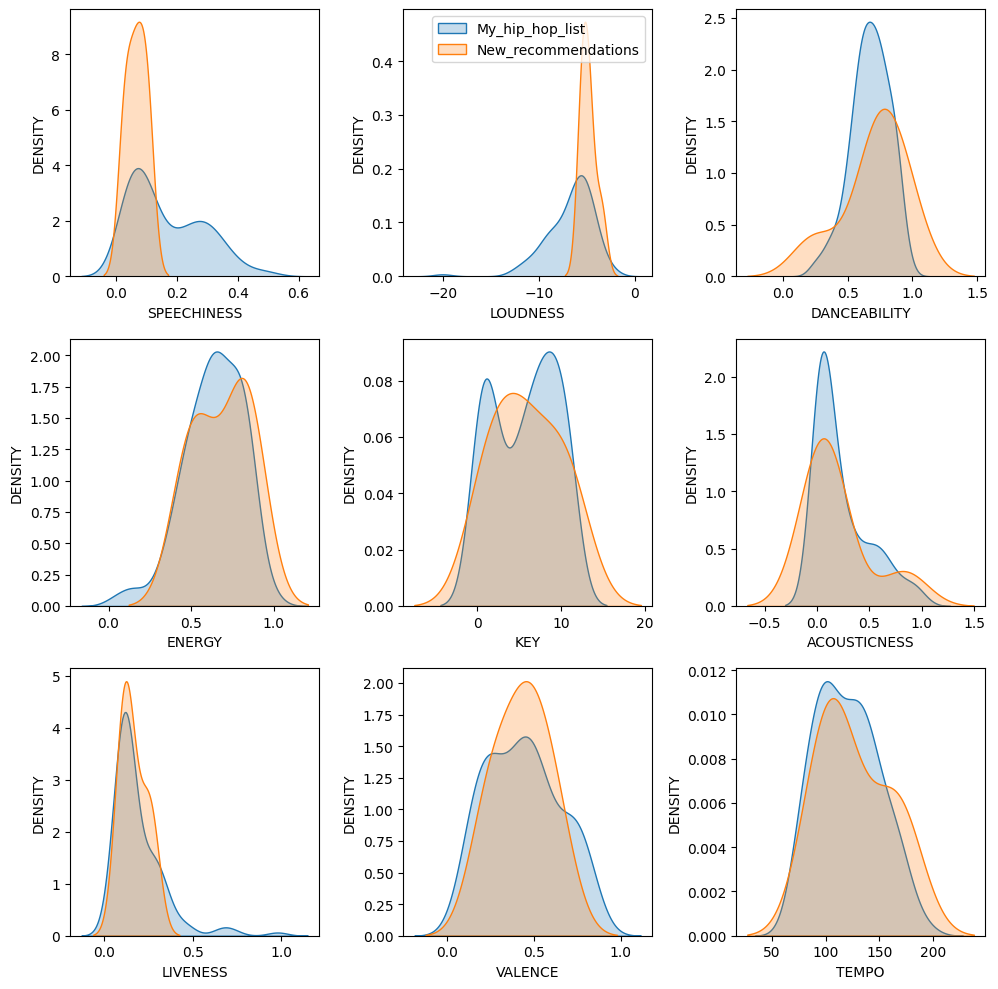

In [64]:
plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(second_compare.columns[2:]): #change this first
    plt.subplot(3, 3, i+1)
    sns.kdeplot(second_compare.loc[second_compare['list'] == 'My_hip_hop_list', col], shade=True, label='My_hip_hop_list')
    sns.kdeplot(second_compare.loc[second_compare['list'] == 'New_recommendations', col], shade=True, label='New_recommendations')

    plt.ylabel('DENSITY')

    plt.xlabel(col.upper())

    if i == 1:
        plt.legend(loc='upper right')
    else:
        plt.legend().remove()

plt.tight_layout()

# the x-axis in kde is range of values in dataset
# the y-axis is the kernel density estimate.

## Conclusion

We can see that now, when we narrow down the genres and then further narrow down to one feature to make a successful knn model then the distance reduces making the song recommendations much more similar according to not just the feature we used to make the model - but all the other features too. The visualizations give us the same evidence.

Now with this under our belt we can go on to making them dollars


<br />
<center>
<img src="daffy-duck-raining-money.gif" width=700 />
</center>